In [35]:
from dataclasses import dataclass
import os
from pathlib import Path

import polars as pl
from matplotlib import pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
import numpy as np
import seaborn as sns
from sklearn.linear_model import LinearRegression

In [2]:
# Definitions

PROCESSED_DATA_PATH: Path = Path("processed")

@dataclass
class ColumnDefinition:
    label: str
    dtype: any


@dataclass
class InstrumentLocationLabels:
    SOD_A_122: str
    SOD_B_081: str
    SOD_A_081: str
    HALSSIAAPA_A_122: str


@dataclass
class PlotAxisLabel:
    label: str


DATETIME_DTYPE = pl.Datetime("ms")
LOCATION_ID = ColumnDefinition(
    label="location_id",
    dtype="string" # not enforces anywhere
)
UTC_MINUTE = ColumnDefinition(
    label="utc_minute",
    dtype=DATETIME_DTYPE
)
XCH4 = ColumnDefinition(
    label="XCH4",
    dtype=pl.Float64
)
XCO2 = ColumnDefinition(
    label="XCO2",
    dtype=pl.Float64
)
XCO = ColumnDefinition(
    label="XCO",
    dtype=pl.Float64
)
XAIR = ColumnDefinition(
    label="XAIR",
    dtype=pl.Float64
)
XCH4_HALSSIAAPA_SOD_RES = ColumnDefinition(
    label="XCH4_HALSSIAAPA_SOD_RES",
    dtype=pl.Float64
)
XCO2_HALSSIAAPA_SOD_RES = ColumnDefinition(
    label="XCO2_HALSSIAAPA_SOD_RES",
    dtype=pl.Float64
)
XCO_HALSSIAAPA_SOD_RES = ColumnDefinition(
    label="XCO_HALSSIAAPA_SOD_RES",
    dtype=pl.Float64
)
XAIR_HALSSIAAPA_SOD_RES = ColumnDefinition(
    label="XAIR_HALSSIAAPA_SOD_RES",
    dtype=pl.Float64
)
INSTRUMENT_LOCATION_LABELS = InstrumentLocationLabels(
    SOD_A_122 = "SOD_A SN122",
    SOD_B_081 = "SOD_B SN081",
    SOD_A_081 = "SOD_A SN081",
    HALSSIAAPA_A_122 = "HALSSIAAPA_A SN122"
)
XCH4_PLOT_LABEL = PlotAxisLabel(
    label="XCH₄ (ppm)"
)
XCH4_PPB_PLOT_LABEL = PlotAxisLabel(
    label="XCH₄ (ppb)"
)
XCO2_PLOT_LABEL = PlotAxisLabel(
    label="XCO₂ (ppm)"
)
XCO_PLOT_LABEL = PlotAxisLabel(
    label="XCO (ppm)"
)
XAIR_PLOT_LABEL = PlotAxisLabel(
    label="XAIR (ppm)"
)

In [3]:
# Data processing functions

def read_csv_with_dtype(file_path, v: bool = True) -> pl.DataFrame:
    df = pl.read_csv(file_path, try_parse_dates=True)
    df = df.with_columns([
        pl.col(UTC_MINUTE.label).cast(UTC_MINUTE.dtype)
    ])
    v and display(df.sample(8))
    return df


def get_col_on_location(df: pl.DataFrame, location: str, col_name: str, v: bool = False) -> pl.DataFrame:
    df = (
        df.filter(pl.col(LOCATION_ID.label) == location)
        .select([
            pl.col(col_name),
            pl.col(UTC_MINUTE.label),
            pl.col("unix_epoch"),
            pl.col("sensor_id"),
            pl.col(LOCATION_ID.label)
        ])
        .sort(UTC_MINUTE.label)
    )
    v and print(df)
    return df


def group_by_day(df: pl.DataFrame, agg_type: str = "median", v: bool = False) -> pl.DataFrame:
    day = ColumnDefinition(
        label = "day",
        dtype = DATETIME_DTYPE
    )
    df = df.with_columns([
        pl.col(UTC_MINUTE.label).dt.truncate("1d").alias(day.label)
    ])

    if agg_type == "median":
        df = (
            df.group_by([day.label])
            .agg([
                pl.col(pl.Float64).median(),
                pl.col("sensor_id").first()
            ])
            .sort([day.label])
        )
    if agg_type == "mean":
        df = (
            df.group_by([day.label])
            .agg([
                pl.col(pl.Float64).mean(),
                pl.col("sensor_id").first()
            ])
            .sort([day.label])
        )
    
    v and print(df)
    return df 

def create_bias_correction(locations_Xgas_df_dict, Xgas_col_name, Xgas_plot_label=None, v=True, show_plots=True):

    Xgas_122_raw: pl.DataFrame = locations_Xgas_df_dict[INSTRUMENT_LOCATION_LABELS.SOD_A_122].select(pl.col(Xgas_col_name))
    Y = Xgas_122_raw
    Xgas_081_raw: pl.DataFrame = locations_Xgas_df_dict[INSTRUMENT_LOCATION_LABELS.SOD_B_081].select(pl.col(Xgas_col_name))
    X = Xgas_081_raw

    reg_model = LinearRegression().fit(X, Y)
    m: float = reg_model.coef_[0][0]
    b: float = reg_model.intercept_[0]
    r_squared: float = reg_model.score(X, Y)

    v and print(f"Slope (m): {m}")
    v and print(f"Intercept (b): {b}")
    v and print(f"R² score: {r_squared}")

    if not show_plots:
        return m, b, r_squared
    
    Xgas_122_raw_pred =  m * Xgas_081_raw + b
    Y_hat = Xgas_122_raw_pred

    if Xgas_plot_label is None:
        raise TypeError(
            "show_plots was set to true but plot label was not provided"
        )
    
    sns.set_theme(style="white", font_scale=1.2)
    # Plotting the data points and the regression line
    plt.figure(figsize=(5, 5))
    plt.scatter(X, Y, label="Data points", color='navy', alpha=0.3)  # Scatter plot of original data
    plt.plot(X, Y_hat, label=f"Fit, R²={r_squared:.3f}\nm={m:.3f}, b={b:.3f}", color='orange')  # Regression line
    plt.xlabel(f"SN081 raw {Xgas_plot_label}")
    plt.ylabel(f"SN122 raw {Xgas_plot_label}")
    plt.legend()
    plt.title("Linear Regression fit")
    plt.grid(True)
    plt.show()

    Xgas_081_corr: pl.DataFrame= apply_instrument_bias_correction(X, Xgas_col_name, m, b).select(Xgas_col_name)
    X_corr = Xgas_081_corr

    plt.figure(figsize=(10, 5))
    plt.plot(X, label="SN081 raw (SOD_B)", color='darkgreen', alpha=0.8, linewidth=2)
    plt.plot(Y, label="SN122 raw (SOD_A)", color="orange", alpha=0.8, linewidth=2)
    plt.plot(X_corr, label="SN081 corrected (SOD_B)", color="black", alpha=0.6, linewidth=2)
    plt.xlabel("Collocated measurement number")
    plt.ylabel(Xgas_plot_label)
    plt.title("Instrument SN081: Raw vs Corrected", pad=15)
    plt.legend(frameon=True, loc="best")
    plt.tight_layout()
    plt.show()
    sns.reset_orig()  # Reset to matplotlib's original RC parameters
    
    return m, b, r_squared


def apply_instrument_bias_correction(df: pl.DataFrame, col_name: str, m: float, b: float, v: bool = True) -> pl.DataFrame:
    df = df.with_columns([
        (m * pl.col(col_name) + b).alias(col_name)
    ])
    v and print(df)
    return df


def ppm_to_ppb(df: pl.DataFrame, col_name: str, v: bool = False) -> pl.DataFrame:
    new_df = df.with_columns([
        (1000 * pl.col(col_name)).alias(f"{col_name}.ppb")
    ])
    v and print(new_df)
    return new_df

def data_dict_ppm_to_ppb(data_dict: dict, v: bool = False) -> dict:
    new_data_dict = {}
    for key in data_dict.keys():
        new_data_dict[key] = ppm_to_ppb(data_dict[key], XCH4.label)
    v and print(new_data_dict)

    return new_data_dict


def calculate_halssiaapa_residuals(df_halssiaapa: pl.DataFrame, df_sod: pl.DataFrame, data_col_label: str, time_col_label: str, res_col_label: str, v: bool = True):
    df = (
        df_halssiaapa.select([
            pl.col(time_col_label),
            pl.col(data_col_label)
        ])
        .join(
            df_sod.select([
                pl.col(time_col_label),
                pl.col(data_col_label)
            ]),
            on=time_col_label,
            how="inner",
            suffix="_SOD_A_081"
        )
        .rename({
            data_col_label: f"{data_col_label}_HALSSIAAPA_A_122"
        })
    )
    df = df.with_columns([
        (pl.col(f"{data_col_label}_HALSSIAAPA_A_122") - pl.col(f"{data_col_label}_SOD_A_081")).alias(res_col_label)
    ])

    v and display(df)
    return df

In [32]:
# Plotting

def plt_raw_and_corrected_species(
    data_dict_uncorrected, x, y, title, xlab, ylab, loc="best", data_dict_corrected=None, fig_path=None
) -> None:
    sns.set_theme(style="whitegrid", font_scale=1.2)
    plt.rcParams.update({
        "axes.titlesize": 18,
        "axes.labelsize": 16,
        "xtick.labelsize": 14,
        "ytick.labelsize": 14,
        "legend.fontsize": 14
    })

    fig, ax = plt.subplots(
        figsize=(11, 6),
        constrained_layout=True
    )
    uncorrected_colors = ["darkred", "navy", "slateblue", "violet"]
    uncorrected_markers = ["+", ".", ".", "+"]
    uncorrected_alphas = [0.9, 0.7, 0.7, 0.9]
    for key, c, m, a in zip(
        data_dict_uncorrected.keys(), uncorrected_colors, uncorrected_markers, uncorrected_alphas
    ):
        sns.scatterplot(data=data_dict_uncorrected[key], x=x, y=y, label=f"{key}.raw", alpha=a, marker=m, color=c, s=100, ax=ax)
    
    if data_dict_corrected is not None:
        corrected_colors = ["teal", "darkgreen"]
        corrected_markers = [".", "."]
        corrected_alphas = [0.5, 0.5]
        corrected_keys = [INSTRUMENT_LOCATION_LABELS.SOD_B_081, INSTRUMENT_LOCATION_LABELS.SOD_A_081]
        for key, c, m, a in zip(
            corrected_keys, corrected_colors, corrected_markers, corrected_alphas
        ):
            sns.scatterplot(data=data_dict_corrected[key], x=x, y=y, label=f"{key}.cor", alpha=a, marker=m, color=c, s=200, ax=ax)
    
    ax.set_title(title)
    ax.set_xlabel(xlab)
    ax.set_ylabel(ylab)
    # plt.xticks(rotation=45)
    for tick in ax.get_xticklabels():
        tick.set_rotation(45)
    # plt.tight_layout()
    ax.legend(loc=loc)
    # fig.tight_layout()
    
    if fig_path is not None and os.path.exists(Path(fig_path).parent):
        fig.savefig(fig_path, dpi=200, bbox_inches='tight')
        print(f"Saveed fig to {fig_path}")
    
    plt.show()
    sns.reset_orig()


def plt_box_residuals(
        df: pl.DataFrame, res_column_label: str, y_lab: str, title: str, fig_path=None
    ):

    df_with_day_col = df.with_columns(
        pl.col(UTC_MINUTE.label).dt.truncate("1d").alias("day")
    )

    # Group by day and collect the values
    daily_groups = df_with_day_col.group_by("day").agg([
        pl.col(res_column_label).alias("daily_groups")
    ]).sort("day")

    # Boxplot takes a list of lists
    box_data = daily_groups["daily_groups"].to_list()
    labels = daily_groups["day"].dt.strftime("%m-%d").to_list()

    # get mean and std for plot annotations
    mean = df[res_column_label].mean()
    std = df[res_column_label].std()
    x_pos = np.arange(1, len(labels) + 1)  # Boxplot x positions

    sns.set_theme(style="whitegrid", font_scale=1.2)
    plt.rcParams.update({
        "axes.titlesize": 18,
        "axes.labelsize": 16,
        "xtick.labelsize": 14,
        "ytick.labelsize": 14,
        "legend.fontsize": 14
    })
    fig, ax = plt.subplots(
        figsize=(11, 6),
        constrained_layout=True
    )
    ax.grid(alpha=0.5)
    
    # Box plot props
    flierprops = dict(
        marker='.', markersize=3, color="darkgreen", markerfacecolor="darkgreen", alpha=0.2
    )
    boxprops = dict(
        color="grey", alpha=1, linewidth=1,
    )
    medianprops = dict(
        color="darkgreen"
    )

    ax.fill_between(x_pos, mean - std, mean + std, color="gray", alpha=0.2, label="±1 std dev")
    ax.axhline(y=mean, color='blue', linestyle='-', linewidth=1, label=f'mean={mean:.3f}', alpha=0.5)
    ax.axhline(y=0, color='black', linestyle='dotted', linewidth=1.5, label=f'zero line', alpha=0.3)
    box = ax.boxplot(
        box_data,
        tick_labels=labels,
        showmeans=False,
        showfliers=True,
        whis=[0, 100],
        patch_artist=True,
        # boxprops=boxprops,
        whiskerprops=boxprops,
        capprops=boxprops,
        medianprops=medianprops,
        flierprops=flierprops,
    )
    
    # color the boxes in to hide the grid
    for patch in box['boxes']:
        patch.set_facecolor("white")
        patch.set_linewidth(1),
        patch.set_edgecolor("grey")
    
    # ax.set_title("Box and Whisker Plot by Day")
    ax.set_title(title)
    ax.set_ylabel(y_lab)
    ax.set_xlabel("Day (mm-dd)")
    for tick in ax.get_xticklabels():
        tick.set_rotation(45)


    # Existing legend entries
    handles = []

    # ±1 std dev (shaded area)
    handles.append(Patch(facecolor='gray', alpha=0.2, label='±1 std dev'))
    # Mean line
    handles.append(Line2D([0], [0], color='blue', lw=1, alpha=0.5, label=f'Mean = {mean:.3f}'))
    # Zero line
    handles.append(Line2D([0], [0], color='black', lw=1.5, linestyle='dotted', alpha=0.3, label='Zero line'))

    # Add median line legend (match medianprops)
    handles.append(Line2D([0], [0], color='darkgreen', lw=1, label='Daily medians'))

    # Add whiskers legend (match boxprops)
    handles.append(Line2D([0], [0], color='grey', lw=1, label='Whiskers (min & max)'))

    # Optional: Add outliers legend (match flierprops)

    ax.legend(handles=handles, loc='best')
    if fig_path is not None and not os.path.exists(Path(fig_path).parent):
        print(f"Warning: fig path supplied but parent directory does not exist: {fig_path}")
    elif fig_path is not None and os.path.exists(Path(fig_path).parent):
        fig.savefig(fig_path, dpi=200, bbox_inches='tight')
        print(f"Saved fig to {fig_path}")
    
    plt.show()
    sns.reset_orig()


def plt_res_distro(df: pl.DataFrame, res_col_label: str, y_label: str):
    df_with_day_col = df.with_columns([
        pl.col(UTC_MINUTE.label).dt.date().alias('day')
    ])

    # Convert to pandas for seaborn
    df_pd = df_with_day_col.select(['day', res_col_label]).to_pandas()

    # Plot overlaid KDEs
    plt.figure(figsize=(11, 4))
    # plt.grid(True)

    for day, group in df_pd.groupby('day'):
        if len(group[res_col_label]) >= 5:  # Optional filter
            sns.kdeplot(
                group[res_col_label],
                bw_adjust=0.6,
                alpha=0.15,
                color='navy',
                fill=True,
                linewidth=0.1
            )

    plt.title('Daily distributions of HALSSIAAPA_A - SOD_A residuals')
    plt.xlabel(y_label)
    plt.ylabel('Density')
    plt.tight_layout()
    plt.show()


In [5]:
collocated_SOD_A_SOD_B = read_csv_with_dtype(PROCESSED_DATA_PATH/"SOD_A_SOD_B_collocated_1min.csv")
collocated_SOD_A_HALSSIAAPA_A = read_csv_with_dtype(PROCESSED_DATA_PATH/"SOD_A_HALSSIAAPA_A_collocated_1min.csv")

# check for null values
assert collocated_SOD_A_SOD_B.null_count().sum_horizontal().item() == 0, "Nulls found in collocated_SOD_A_SOD_B"
assert collocated_SOD_A_HALSSIAAPA_A.null_count().sum_horizontal().item() == 0, "Nulls found in collocated_SOD_A_HALSSIAAPA_A"
print("No nulls found.")

utc_minute,sensor_id,location_id,ground_pressure,lat,lon,alt,sza,azi,XH2O,XAIR,XCO2,XCH4,XCO2_STR,XCO,XCH4_S5P,H2O,O2,CO2,CH4,CO,CH4_S5P,n_measurements,unix_epoch
datetime[ms],str,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,i64,f64
2022-08-03 11:44:00,"""SN122""","""SOD_A""",985.53,67.367,26.631,182.2,51.74,25.94,2062.15,1.00142,409.767,1.86498,410.938,0.0751656,1.86857,4.3016e26,4.4054e28,8.5696e25,3.9360e23,1.5781e22,3.9167e23,1,1.6595e9
2022-05-25 08:48:00,"""SN122""","""SOD_A""",987.94,67.367,26.631,182.2,48.15,-26.0,2243.71,1.00235,417.984,1.86239,418.242,0.0878396,1.86738,4.6957e26,4.4189e28,8.7719e25,3.9442e23,1.8539e22,3.9275e23,1,1.6535e9
2022-08-26 10:50:00,"""SN122""","""SOD_A""",996.2,67.367,26.631,182.2,57.31,10.2,4236.71,1.00198,411.603,1.8804,411.821,0.0770004,1.88183,8.9265e26,4.4516e28,8.7159e25,4.0139e23,1.6275e22,3.9905e23,1,1.6615e9
2022-08-26 09:58:00,"""SN081""","""SOD_B""",999.82,67.367,26.631,179.4,57.07,-4.83,4226.94,0.996557,411.887,1.8826,411.358,0.0777383,1.88432,8.8899e26,4.4435e28,8.7061e25,4.0114e23,1.6405e22,3.9886e23,1,1.6615e9
2023-07-03 08:07:00,"""SN122""","""SOD_A""",971.43,67.367,26.631,182.2,48.79,-41.28,1495.19,1.00338,415.89,1.8606,416.014,0.089599,1.86648,3.0815e26,4.3517e28,8.5875e25,3.8782e23,1.8612e22,3.8637e23,1,1.6884e9
2022-08-26 11:12:00,"""SN081""","""SOD_B""",999.37,67.367,26.631,179.4,57.81,16.63,4238.46,0.996238,411.376,1.8831,410.87,0.0775346,1.88504,8.9072e26,4.4403e28,8.6887e25,4.0093e23,1.6339e22,3.9871e23,1,1.6615e9
2022-06-28 12:01:00,"""SN122""","""SOD_A""",1001.35,67.367,26.631,182.2,47.01,33.7,4418.0,1.00061,412.765,1.88012,413.165,0.0788055,1.88396,9.3427e26,4.4648e28,8.7749e25,4.0298e23,1.6826e22,4.0100e23,1,1.6564e9
2022-09-08 10:32:00,"""SN081""","""SOD_B""",1001.87,67.367,26.631,179.4,61.83,5.99,2601.71,0.995476,411.675,1.88099,411.619,0.0777262,1.8827,5.4826e26,4.4545e28,8.7022e25,4.0102e23,1.6355e22,3.9885e23,1,1.6626e9


utc_minute,sensor_id,location_id,ground_pressure,lat,lon,alt,sza,azi,XH2O,XAIR,XCO2,XCH4,XCO2_STR,XCO,XCH4_S5P,H2O,O2,CO2,CH4,CO,CH4_S5P,n_measurements,unix_epoch
datetime[ms],str,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,i64,f64
2024-08-23 10:38:00,"""SN081""","""SOD_A""",979.04,67.367,26.631,182.2,56.28,6.72,3153.59,1.00061,417.992,1.90556,419.073,0.111372,1.91003,6.5254e26,4.3713e28,8.6818e25,3.9918e23,2.3130e22,3.9746e23,1,1.7244e9
2024-08-08 12:38:00,"""SN122""","""HALSSIAAPA_A""",993.41,67.368,26.654,180.9,56.16,41.43,2425.18,0.996349,415.087,1.90925,415.685,0.108329,1.91229,5.0724e26,4.4186e28,8.7074e25,4.0406e23,2.2738e22,4.0202e23,1,1.7231e9
2024-09-01 08:13:00,"""SN081""","""SOD_A""",1000.23,67.367,26.631,182.2,62.63,-33.85,2000.78,1.0012,416.746,1.89185,416.899,0.104985,1.89266,4.2351e26,4.4748e28,8.8426e25,4.0494e23,2.2167e22,4.0258e23,1,1.7252e9
2024-05-08 10:24:00,"""SN122""","""HALSSIAAPA_A""",1007.52,67.368,26.654,180.9,50.12,4.45,610.568,0.996978,425.154,1.87762,425.333,0.0928842,1.88412,1.2975e26,4.4873e28,9.0425e25,4.0327e23,1.9876e22,4.0190e23,1,1.7152e9
2024-05-30 09:40:00,"""SN081""","""SOD_A""",991.61,67.367,26.631,182.2,45.74,-9.94,3496.19,1.00045,419.627,1.90186,419.451,0.0944774,1.9055,7.3244e26,4.4229e28,8.8282e25,4.0358e23,1.9990e22,4.0153e23,1,1.7171e9
2024-05-08 10:13:00,"""SN122""","""HALSSIAAPA_A""",1007.62,67.368,26.654,180.9,50.07,1.26,615.228,0.996916,425.118,1.8781,425.107,0.0933408,1.88436,1.3074e26,4.4874e28,9.0421e25,4.0339e23,1.9974e22,4.0196e23,1,1.7152e9
2024-08-12 14:15:00,"""SN081""","""SOD_A""",985.53,67.367,26.631,182.2,64.84,66.63,3834.32,0.998982,411.073,1.92136,411.127,0.10004,1.9257,7.9701e26,4.3956e28,8.5831e25,4.0432e23,2.0703e22,4.0278e23,1,1.7235e9
2024-07-21 16:06:00,"""SN081""","""SOD_A""",992.41,67.367,26.631,182.2,70.01,95.02,1752.57,0.999252,415.905,1.89944,418.601,0.0968447,1.90779,3.6741e26,4.4375e28,8.7366e25,4.0229e23,2.0060e22,4.0185e23,1,1.7216e9


No nulls found.


In [6]:
# prepare full raw collocated data for plotting XCH4
v = False
col_name = XCH4.label
locations_XCH4: dict = {
    INSTRUMENT_LOCATION_LABELS.SOD_A_122: get_col_on_location(collocated_SOD_A_SOD_B, "SOD_A", col_name, v=v),
    INSTRUMENT_LOCATION_LABELS.SOD_B_081: get_col_on_location(collocated_SOD_A_SOD_B, "SOD_B", col_name, v=v),
    INSTRUMENT_LOCATION_LABELS.SOD_A_081: get_col_on_location(collocated_SOD_A_HALSSIAAPA_A, "SOD_A", col_name, v=v),
    INSTRUMENT_LOCATION_LABELS.HALSSIAAPA_A_122: get_col_on_location(collocated_SOD_A_HALSSIAAPA_A, "HALSSIAAPA_A", col_name, v=v)
}

for key in locations_XCH4.keys():
    print(key)
    display(locations_XCH4[key].sample(8))
    print("mean:", locations_XCH4[key].mean())
    print("median:", locations_XCH4[key].median())
    print("std:", locations_XCH4[key].std())

SOD_A SN122


XCH4,utc_minute,unix_epoch,sensor_id,location_id
f64,datetime[ms],f64,str,str
1.87552,2022-07-21 08:07:00,1.6584e9,"""SN122""","""SOD_A"""
1.86232,2022-05-25 06:58:00,1.6535e9,"""SN122""","""SOD_A"""
1.88141,2022-08-26 10:29:00,1.6615e9,"""SN122""","""SOD_A"""
1.88644,2022-08-25 14:06:00,1.6614e9,"""SN122""","""SOD_A"""
1.87894,2023-04-27 16:49:00,1.6826e9,"""SN122""","""SOD_A"""
1.87878,2022-08-15 08:17:00,1.6606e9,"""SN122""","""SOD_A"""
1.87634,2022-08-23 07:38:00,1.6612e9,"""SN122""","""SOD_A"""
1.87502,2022-06-29 07:02:00,1.6565e9,"""SN122""","""SOD_A"""


mean: shape: (1, 5)
┌─────────┬─────────────────────────┬────────────┬───────────┬─────────────┐
│ XCH4    ┆ utc_minute              ┆ unix_epoch ┆ sensor_id ┆ location_id │
│ ---     ┆ ---                     ┆ ---        ┆ ---       ┆ ---         │
│ f64     ┆ datetime[ms]            ┆ f64        ┆ str       ┆ str         │
╞═════════╪═════════════════════════╪════════════╪═══════════╪═════════════╡
│ 1.87585 ┆ 2022-11-09 03:03:07.331 ┆ 1.6680e9   ┆ null      ┆ null        │
└─────────┴─────────────────────────┴────────────┴───────────┴─────────────┘
median: shape: (1, 5)
┌─────────┬─────────────────────┬────────────┬───────────┬─────────────┐
│ XCH4    ┆ utc_minute          ┆ unix_epoch ┆ sensor_id ┆ location_id │
│ ---     ┆ ---                 ┆ ---        ┆ ---       ┆ ---         │
│ f64     ┆ datetime[ms]        ┆ f64        ┆ str       ┆ str         │
╞═════════╪═════════════════════╪════════════╪═══════════╪═════════════╡
│ 1.87712 ┆ 2022-08-25 09:42:00 ┆ 1.6614e9   ┆ null   

XCH4,utc_minute,unix_epoch,sensor_id,location_id
f64,datetime[ms],f64,str,str
1.87334,2023-06-29 08:48:00,1.6880e9,"""SN081""","""SOD_B"""
1.88097,2022-06-29 12:08:00,1.6565e9,"""SN081""","""SOD_B"""
1.88031,2023-04-27 16:52:00,1.6826e9,"""SN081""","""SOD_B"""
1.87526,2023-06-29 07:22:00,1.6880e9,"""SN081""","""SOD_B"""
1.88889,2023-08-08 10:53:00,1.6915e9,"""SN081""","""SOD_B"""
1.87654,2022-08-23 11:35:00,1.6613e9,"""SN081""","""SOD_B"""
1.85772,2022-05-24 08:49:00,1.6534e9,"""SN081""","""SOD_B"""
1.88138,2022-07-04 06:12:00,1.6569e9,"""SN081""","""SOD_B"""


mean: shape: (1, 5)
┌──────────┬─────────────────────────┬────────────┬───────────┬─────────────┐
│ XCH4     ┆ utc_minute              ┆ unix_epoch ┆ sensor_id ┆ location_id │
│ ---      ┆ ---                     ┆ ---        ┆ ---       ┆ ---         │
│ f64      ┆ datetime[ms]            ┆ f64        ┆ str       ┆ str         │
╞══════════╪═════════════════════════╪════════════╪═══════════╪═════════════╡
│ 1.877945 ┆ 2022-11-09 03:03:07.331 ┆ 1.6680e9   ┆ null      ┆ null        │
└──────────┴─────────────────────────┴────────────┴───────────┴─────────────┘
median: shape: (1, 5)
┌─────────┬─────────────────────┬────────────┬───────────┬─────────────┐
│ XCH4    ┆ utc_minute          ┆ unix_epoch ┆ sensor_id ┆ location_id │
│ ---     ┆ ---                 ┆ ---        ┆ ---       ┆ ---         │
│ f64     ┆ datetime[ms]        ┆ f64        ┆ str       ┆ str         │
╞═════════╪═════════════════════╪════════════╪═══════════╪═════════════╡
│ 1.87925 ┆ 2022-08-25 09:42:00 ┆ 1.6614e9   ┆ 

XCH4,utc_minute,unix_epoch,sensor_id,location_id
f64,datetime[ms],f64,str,str
1.9106,2024-07-24 06:30:00,1.7218e9,"""SN081""","""SOD_A"""
1.90449,2024-07-22 09:20:00,1.7216e9,"""SN081""","""SOD_A"""
1.89923,2024-07-21 16:18:00,1.7216e9,"""SN081""","""SOD_A"""
1.90696,2024-07-26 10:56:00,1.7220e9,"""SN081""","""SOD_A"""
1.89788,2024-09-01 13:28:00,1.7252e9,"""SN081""","""SOD_A"""
1.89368,2024-08-18 12:52:00,1.7240e9,"""SN081""","""SOD_A"""
1.90177,2024-07-21 13:26:00,1.7216e9,"""SN081""","""SOD_A"""
1.88959,2024-07-14 11:58:00,1.7210e9,"""SN081""","""SOD_A"""


mean: shape: (1, 5)
┌──────────┬─────────────────────────┬────────────┬───────────┬─────────────┐
│ XCH4     ┆ utc_minute              ┆ unix_epoch ┆ sensor_id ┆ location_id │
│ ---      ┆ ---                     ┆ ---        ┆ ---       ┆ ---         │
│ f64      ┆ datetime[ms]            ┆ f64        ┆ str       ┆ str         │
╞══════════╪═════════════════════════╪════════════╪═══════════╪═════════════╡
│ 1.898892 ┆ 2024-07-25 15:22:10.375 ┆ 1.7219e9   ┆ null      ┆ null        │
└──────────┴─────────────────────────┴────────────┴───────────┴─────────────┘
median: shape: (1, 5)
┌─────────┬─────────────────────┬────────────┬───────────┬─────────────┐
│ XCH4    ┆ utc_minute          ┆ unix_epoch ┆ sensor_id ┆ location_id │
│ ---     ┆ ---                 ┆ ---        ┆ ---       ┆ ---         │
│ f64     ┆ datetime[ms]        ┆ f64        ┆ str       ┆ str         │
╞═════════╪═════════════════════╪════════════╪═══════════╪═════════════╡
│ 1.90148 ┆ 2024-07-26 06:53:00 ┆ 1.7220e9   ┆ 

XCH4,utc_minute,unix_epoch,sensor_id,location_id
f64,datetime[ms],f64,str,str
1.9034,2024-07-22 14:06:00,1.7217e9,"""SN122""","""HALSSIAAPA_A"""
1.90429,2024-07-21 15:05:00,1.7216e9,"""SN122""","""HALSSIAAPA_A"""
1.91451,2024-08-09 08:49:00,1.7232e9,"""SN122""","""HALSSIAAPA_A"""
1.9052,2024-05-30 11:23:00,1.7171e9,"""SN122""","""HALSSIAAPA_A"""
1.89835,2024-09-01 11:25:00,1.7252e9,"""SN122""","""HALSSIAAPA_A"""
1.90835,2024-08-08 12:42:00,1.7231e9,"""SN122""","""HALSSIAAPA_A"""
1.85615,2024-04-19 14:44:00,1.7135e9,"""SN122""","""HALSSIAAPA_A"""
1.89693,2024-09-01 10:50:00,1.7252e9,"""SN122""","""HALSSIAAPA_A"""


mean: shape: (1, 5)
┌──────────┬─────────────────────────┬────────────┬───────────┬─────────────┐
│ XCH4     ┆ utc_minute              ┆ unix_epoch ┆ sensor_id ┆ location_id │
│ ---      ┆ ---                     ┆ ---        ┆ ---       ┆ ---         │
│ f64      ┆ datetime[ms]            ┆ f64        ┆ str       ┆ str         │
╞══════════╪═════════════════════════╪════════════╪═══════════╪═════════════╡
│ 1.900885 ┆ 2024-07-25 15:22:10.375 ┆ 1.7219e9   ┆ null      ┆ null        │
└──────────┴─────────────────────────┴────────────┴───────────┴─────────────┘
median: shape: (1, 5)
┌────────┬─────────────────────┬────────────┬───────────┬─────────────┐
│ XCH4   ┆ utc_minute          ┆ unix_epoch ┆ sensor_id ┆ location_id │
│ ---    ┆ ---                 ┆ ---        ┆ ---       ┆ ---         │
│ f64    ┆ datetime[ms]        ┆ f64        ┆ str       ┆ str         │
╞════════╪═════════════════════╪════════════╪═══════════╪═════════════╡
│ 1.9039 ┆ 2024-07-26 06:53:00 ┆ 1.7220e9   ┆ null  

In [7]:
# prepare full raw collocated data for plotting XC02
v = False
col_name = XCO2.label
locations_XCO2: dict = {
    INSTRUMENT_LOCATION_LABELS.SOD_A_122: get_col_on_location(collocated_SOD_A_SOD_B, "SOD_A", col_name, v=v),
    INSTRUMENT_LOCATION_LABELS.SOD_B_081: get_col_on_location(collocated_SOD_A_SOD_B, "SOD_B", col_name, v=v),
    INSTRUMENT_LOCATION_LABELS.SOD_A_081: get_col_on_location(collocated_SOD_A_HALSSIAAPA_A, "SOD_A", col_name, v=v),
    INSTRUMENT_LOCATION_LABELS.HALSSIAAPA_A_122: get_col_on_location(collocated_SOD_A_HALSSIAAPA_A, "HALSSIAAPA_A", col_name, v=v)
}

for key in locations_XCO2.keys():
    print(key)
    display(locations_XCO2[key].sample(8))
    print("mean:", locations_XCO2[key].mean())
    print("median:", locations_XCO2[key].median())
    print("std:", locations_XCO2[key].std())

SOD_A SN122


XCO2,utc_minute,unix_epoch,sensor_id,location_id
f64,datetime[ms],f64,str,str
411.765,2022-09-08 10:39:00,1.6626e9,"""SN122""","""SOD_A"""
414.027,2022-06-29 06:44:00,1.6565e9,"""SN122""","""SOD_A"""
414.356,2023-07-11 09:40:00,1.6891e9,"""SN122""","""SOD_A"""
416.328,2023-07-03 06:45:00,1.6884e9,"""SN122""","""SOD_A"""
413.48,2022-10-07 09:50:00,1.6651e9,"""SN122""","""SOD_A"""
411.588,2022-08-16 07:04:00,1.6606e9,"""SN122""","""SOD_A"""
410.884,2022-08-23 10:46:00,1.6613e9,"""SN122""","""SOD_A"""
414.352,2023-07-11 08:09:00,1.6891e9,"""SN122""","""SOD_A"""


mean: shape: (1, 5)
┌────────────┬─────────────────────────┬────────────┬───────────┬─────────────┐
│ XCO2       ┆ utc_minute              ┆ unix_epoch ┆ sensor_id ┆ location_id │
│ ---        ┆ ---                     ┆ ---        ┆ ---       ┆ ---         │
│ f64        ┆ datetime[ms]            ┆ f64        ┆ str       ┆ str         │
╞════════════╪═════════════════════════╪════════════╪═══════════╪═════════════╡
│ 413.757312 ┆ 2022-11-09 03:03:07.331 ┆ 1.6680e9   ┆ null      ┆ null        │
└────────────┴─────────────────────────┴────────────┴───────────┴─────────────┘
median: shape: (1, 5)
┌─────────┬─────────────────────┬────────────┬───────────┬─────────────┐
│ XCO2    ┆ utc_minute          ┆ unix_epoch ┆ sensor_id ┆ location_id │
│ ---     ┆ ---                 ┆ ---        ┆ ---       ┆ ---         │
│ f64     ┆ datetime[ms]        ┆ f64        ┆ str       ┆ str         │
╞═════════╪═════════════════════╪════════════╪═══════════╪═════════════╡
│ 413.784 ┆ 2022-08-25 09:42:00 ┆

XCO2,utc_minute,unix_epoch,sensor_id,location_id
f64,datetime[ms],f64,str,str
417.907,2022-05-25 07:38:00,1.6535e9,"""SN081""","""SOD_B"""
414.173,2022-06-29 10:13:00,1.6565e9,"""SN081""","""SOD_B"""
413.964,2022-07-04 06:36:00,1.6569e9,"""SN081""","""SOD_B"""
409.532,2022-08-03 11:52:00,1.6595e9,"""SN081""","""SOD_B"""
412.614,2022-06-28 11:54:00,1.6564e9,"""SN081""","""SOD_B"""
414.232,2022-06-29 10:29:00,1.6565e9,"""SN081""","""SOD_B"""
414.113,2022-06-29 09:21:00,1.6565e9,"""SN081""","""SOD_B"""
410.824,2022-08-16 08:56:00,1.6606e9,"""SN081""","""SOD_B"""


mean: shape: (1, 5)
┌────────────┬─────────────────────────┬────────────┬───────────┬─────────────┐
│ XCO2       ┆ utc_minute              ┆ unix_epoch ┆ sensor_id ┆ location_id │
│ ---        ┆ ---                     ┆ ---        ┆ ---       ┆ ---         │
│ f64        ┆ datetime[ms]            ┆ f64        ┆ str       ┆ str         │
╞════════════╪═════════════════════════╪════════════╪═══════════╪═════════════╡
│ 413.638115 ┆ 2022-11-09 03:03:07.331 ┆ 1.6680e9   ┆ null      ┆ null        │
└────────────┴─────────────────────────┴────────────┴───────────┴─────────────┘
median: shape: (1, 5)
┌────────┬─────────────────────┬────────────┬───────────┬─────────────┐
│ XCO2   ┆ utc_minute          ┆ unix_epoch ┆ sensor_id ┆ location_id │
│ ---    ┆ ---                 ┆ ---        ┆ ---       ┆ ---         │
│ f64    ┆ datetime[ms]        ┆ f64        ┆ str       ┆ str         │
╞════════╪═════════════════════╪════════════╪═══════════╪═════════════╡
│ 413.66 ┆ 2022-08-25 09:42:00 ┆ 1.661

XCO2,utc_minute,unix_epoch,sensor_id,location_id
f64,datetime[ms],f64,str,str
417.574,2024-08-23 11:42:00,1.7244e9,"""SN081""","""SOD_A"""
417.16,2024-08-27 15:03:00,1.7248e9,"""SN081""","""SOD_A"""
413.951,2024-08-08 12:12:00,1.7231e9,"""SN081""","""SOD_A"""
414.554,2024-07-24 06:56:00,1.7218e9,"""SN081""","""SOD_A"""
411.635,2024-08-12 13:12:00,1.7235e9,"""SN081""","""SOD_A"""
423.958,2024-05-08 12:28:00,1.7152e9,"""SN081""","""SOD_A"""
414.176,2024-08-08 13:26:00,1.7231e9,"""SN081""","""SOD_A"""
416.142,2024-07-14 09:48:00,1.7210e9,"""SN081""","""SOD_A"""


mean: shape: (1, 5)
┌────────────┬─────────────────────────┬────────────┬───────────┬─────────────┐
│ XCO2       ┆ utc_minute              ┆ unix_epoch ┆ sensor_id ┆ location_id │
│ ---        ┆ ---                     ┆ ---        ┆ ---       ┆ ---         │
│ f64        ┆ datetime[ms]            ┆ f64        ┆ str       ┆ str         │
╞════════════╪═════════════════════════╪════════════╪═══════════╪═════════════╡
│ 416.599521 ┆ 2024-07-25 15:22:10.375 ┆ 1.7219e9   ┆ null      ┆ null        │
└────────────┴─────────────────────────┴────────────┴───────────┴─────────────┘
median: shape: (1, 5)
┌─────────┬─────────────────────┬────────────┬───────────┬─────────────┐
│ XCO2    ┆ utc_minute          ┆ unix_epoch ┆ sensor_id ┆ location_id │
│ ---     ┆ ---                 ┆ ---        ┆ ---       ┆ ---         │
│ f64     ┆ datetime[ms]        ┆ f64        ┆ str       ┆ str         │
╞═════════╪═════════════════════╪════════════╪═══════════╪═════════════╡
│ 416.112 ┆ 2024-07-26 06:53:00 ┆

XCO2,utc_minute,unix_epoch,sensor_id,location_id
f64,datetime[ms],f64,str,str
420.567,2024-05-30 09:49:00,1.7171e9,"""SN122""","""HALSSIAAPA_A"""
420.222,2024-05-30 13:14:00,1.7171e9,"""SN122""","""HALSSIAAPA_A"""
416.934,2024-07-14 16:07:00,1.7210e9,"""SN122""","""HALSSIAAPA_A"""
416.445,2024-08-26 08:13:00,1.7247e9,"""SN122""","""HALSSIAAPA_A"""
416.797,2024-07-14 14:18:00,1.7210e9,"""SN122""","""HALSSIAAPA_A"""
416.372,2024-08-26 08:03:00,1.7247e9,"""SN122""","""HALSSIAAPA_A"""
418.454,2024-08-23 11:38:00,1.7244e9,"""SN122""","""HALSSIAAPA_A"""
416.027,2024-07-21 08:45:00,1.7216e9,"""SN122""","""HALSSIAAPA_A"""


mean: shape: (1, 5)
┌────────────┬─────────────────────────┬────────────┬───────────┬─────────────┐
│ XCO2       ┆ utc_minute              ┆ unix_epoch ┆ sensor_id ┆ location_id │
│ ---        ┆ ---                     ┆ ---        ┆ ---       ┆ ---         │
│ f64        ┆ datetime[ms]            ┆ f64        ┆ str       ┆ str         │
╞════════════╪═════════════════════════╪════════════╪═══════════╪═════════════╡
│ 417.520792 ┆ 2024-07-25 15:22:10.375 ┆ 1.7219e9   ┆ null      ┆ null        │
└────────────┴─────────────────────────┴────────────┴───────────┴─────────────┘
median: shape: (1, 5)
┌─────────┬─────────────────────┬────────────┬───────────┬─────────────┐
│ XCO2    ┆ utc_minute          ┆ unix_epoch ┆ sensor_id ┆ location_id │
│ ---     ┆ ---                 ┆ ---        ┆ ---       ┆ ---         │
│ f64     ┆ datetime[ms]        ┆ f64        ┆ str       ┆ str         │
╞═════════╪═════════════════════╪════════════╪═══════════╪═════════════╡
│ 417.004 ┆ 2024-07-26 06:53:00 ┆

In [8]:
# prepare full raw collocated data for plotting XC0
v = False
col_name = XCO.label
locations_XCO: dict = {
    INSTRUMENT_LOCATION_LABELS.SOD_A_122: get_col_on_location(collocated_SOD_A_SOD_B, "SOD_A", col_name, v=v),
    INSTRUMENT_LOCATION_LABELS.SOD_B_081: get_col_on_location(collocated_SOD_A_SOD_B, "SOD_B", col_name, v=v),
    INSTRUMENT_LOCATION_LABELS.SOD_A_081: get_col_on_location(collocated_SOD_A_HALSSIAAPA_A, "SOD_A", col_name, v=v),
    INSTRUMENT_LOCATION_LABELS.HALSSIAAPA_A_122: get_col_on_location(collocated_SOD_A_HALSSIAAPA_A, "HALSSIAAPA_A", col_name, v=v)
}

for key in locations_XCO.keys():
    print(key)
    display(locations_XCO[key].sample(8))
    print("mean:", locations_XCO[key].mean())
    print("median:", locations_XCO[key].median())
    print("std:", locations_XCO[key].std())

SOD_A SN122


XCO,utc_minute,unix_epoch,sensor_id,location_id
f64,datetime[ms],f64,str,str
0.110536,2023-07-11 08:47:00,1.6891e9,"""SN122""","""SOD_A"""
0.0756737,2022-10-07 08:43:00,1.6651e9,"""SN122""","""SOD_A"""
0.0757935,2022-10-07 08:42:00,1.6651e9,"""SN122""","""SOD_A"""
0.0807453,2022-06-28 09:10:00,1.6564e9,"""SN122""","""SOD_A"""
0.0648086,2022-07-07 06:46:00,1.6572e9,"""SN122""","""SOD_A"""
0.0943643,2023-04-27 15:19:00,1.6826e9,"""SN122""","""SOD_A"""
0.08036,2022-06-28 09:25:00,1.6564e9,"""SN122""","""SOD_A"""
0.0883734,2022-08-16 09:30:00,1.6606e9,"""SN122""","""SOD_A"""


mean: shape: (1, 5)
┌──────────┬─────────────────────────┬────────────┬───────────┬─────────────┐
│ XCO      ┆ utc_minute              ┆ unix_epoch ┆ sensor_id ┆ location_id │
│ ---      ┆ ---                     ┆ ---        ┆ ---       ┆ ---         │
│ f64      ┆ datetime[ms]            ┆ f64        ┆ str       ┆ str         │
╞══════════╪═════════════════════════╪════════════╪═══════════╪═════════════╡
│ 0.083882 ┆ 2022-11-09 03:03:07.331 ┆ 1.6680e9   ┆ null      ┆ null        │
└──────────┴─────────────────────────┴────────────┴───────────┴─────────────┘
median: shape: (1, 5)
┌───────────┬─────────────────────┬────────────┬───────────┬─────────────┐
│ XCO       ┆ utc_minute          ┆ unix_epoch ┆ sensor_id ┆ location_id │
│ ---       ┆ ---                 ┆ ---        ┆ ---       ┆ ---         │
│ f64       ┆ datetime[ms]        ┆ f64        ┆ str       ┆ str         │
╞═══════════╪═════════════════════╪════════════╪═══════════╪═════════════╡
│ 0.0798231 ┆ 2022-08-25 09:42:00 ┆ 1

XCO,utc_minute,unix_epoch,sensor_id,location_id
f64,datetime[ms],f64,str,str
0.0765048,2022-08-25 15:40:00,1.6614e9,"""SN081""","""SOD_B"""
0.076744,2022-08-26 12:15:00,1.6615e9,"""SN081""","""SOD_B"""
0.0778727,2022-07-04 06:07:00,1.6569e9,"""SN081""","""SOD_B"""
0.076563,2022-08-03 11:56:00,1.6595e9,"""SN081""","""SOD_B"""
0.101694,2023-07-10 12:27:00,1.6890e9,"""SN081""","""SOD_B"""
0.0943845,2023-04-27 12:10:00,1.6826e9,"""SN081""","""SOD_B"""
0.0775601,2022-06-29 11:36:00,1.6565e9,"""SN081""","""SOD_B"""
0.0774479,2022-07-04 06:09:00,1.6569e9,"""SN081""","""SOD_B"""


mean: shape: (1, 5)
┌──────────┬─────────────────────────┬────────────┬───────────┬─────────────┐
│ XCO      ┆ utc_minute              ┆ unix_epoch ┆ sensor_id ┆ location_id │
│ ---      ┆ ---                     ┆ ---        ┆ ---       ┆ ---         │
│ f64      ┆ datetime[ms]            ┆ f64        ┆ str       ┆ str         │
╞══════════╪═════════════════════════╪════════════╪═══════════╪═════════════╡
│ 0.084335 ┆ 2022-11-09 03:03:07.331 ┆ 1.6680e9   ┆ null      ┆ null        │
└──────────┴─────────────────────────┴────────────┴───────────┴─────────────┘
median: shape: (1, 5)
┌───────────┬─────────────────────┬────────────┬───────────┬─────────────┐
│ XCO       ┆ utc_minute          ┆ unix_epoch ┆ sensor_id ┆ location_id │
│ ---       ┆ ---                 ┆ ---        ┆ ---       ┆ ---         │
│ f64       ┆ datetime[ms]        ┆ f64        ┆ str       ┆ str         │
╞═══════════╪═════════════════════╪════════════╪═══════════╪═════════════╡
│ 0.0804667 ┆ 2022-08-25 09:42:00 ┆ 1

XCO,utc_minute,unix_epoch,sensor_id,location_id
f64,datetime[ms],f64,str,str
0.0897091,2024-07-18 06:17:00,1.7213e9,"""SN081""","""SOD_A"""
0.09367,2024-05-08 09:39:00,1.7152e9,"""SN081""","""SOD_A"""
0.0900807,2024-07-14 15:14:00,1.7210e9,"""SN081""","""SOD_A"""
0.107807,2024-08-28 05:47:00,1.7248e9,"""SN081""","""SOD_A"""
0.0965006,2024-07-21 10:00:00,1.7216e9,"""SN081""","""SOD_A"""
0.124789,2024-08-18 10:13:00,1.7240e9,"""SN081""","""SOD_A"""
0.0959894,2024-07-21 12:14:00,1.7216e9,"""SN081""","""SOD_A"""
0.1058,2024-08-13 07:15:00,1.7235e9,"""SN081""","""SOD_A"""


mean: shape: (1, 5)
┌──────────┬─────────────────────────┬────────────┬───────────┬─────────────┐
│ XCO      ┆ utc_minute              ┆ unix_epoch ┆ sensor_id ┆ location_id │
│ ---      ┆ ---                     ┆ ---        ┆ ---       ┆ ---         │
│ f64      ┆ datetime[ms]            ┆ f64        ┆ str       ┆ str         │
╞══════════╪═════════════════════════╪════════════╪═══════════╪═════════════╡
│ 0.101056 ┆ 2024-07-25 15:22:10.375 ┆ 1.7219e9   ┆ null      ┆ null        │
└──────────┴─────────────────────────┴────────────┴───────────┴─────────────┘
median: shape: (1, 5)
┌───────────┬─────────────────────┬────────────┬───────────┬─────────────┐
│ XCO       ┆ utc_minute          ┆ unix_epoch ┆ sensor_id ┆ location_id │
│ ---       ┆ ---                 ┆ ---        ┆ ---       ┆ ---         │
│ f64       ┆ datetime[ms]        ┆ f64        ┆ str       ┆ str         │
╞═══════════╪═════════════════════╪════════════╪═══════════╪═════════════╡
│ 0.0967675 ┆ 2024-07-26 06:53:00 ┆ 1

XCO,utc_minute,unix_epoch,sensor_id,location_id
f64,datetime[ms],f64,str,str
0.12502,2024-08-18 10:06:00,1.7240e9,"""SN122""","""HALSSIAAPA_A"""
0.111511,2024-09-01 15:31:00,1.7252e9,"""SN122""","""HALSSIAAPA_A"""
0.111854,2024-08-29 08:04:00,1.7249e9,"""SN122""","""HALSSIAAPA_A"""
0.111408,2024-08-23 10:22:00,1.7244e9,"""SN122""","""HALSSIAAPA_A"""
0.0814468,2024-07-16 16:17:00,1.7211e9,"""SN122""","""HALSSIAAPA_A"""
0.102925,2024-09-01 10:04:00,1.7252e9,"""SN122""","""HALSSIAAPA_A"""
0.159999,2024-08-18 11:18:00,1.7240e9,"""SN122""","""HALSSIAAPA_A"""
0.0916248,2024-07-22 15:34:00,1.7217e9,"""SN122""","""HALSSIAAPA_A"""


mean: shape: (1, 5)
┌──────────┬─────────────────────────┬────────────┬───────────┬─────────────┐
│ XCO      ┆ utc_minute              ┆ unix_epoch ┆ sensor_id ┆ location_id │
│ ---      ┆ ---                     ┆ ---        ┆ ---       ┆ ---         │
│ f64      ┆ datetime[ms]            ┆ f64        ┆ str       ┆ str         │
╞══════════╪═════════════════════════╪════════════╪═══════════╪═════════════╡
│ 0.100081 ┆ 2024-07-25 15:22:10.375 ┆ 1.7219e9   ┆ null      ┆ null        │
└──────────┴─────────────────────────┴────────────┴───────────┴─────────────┘
median: shape: (1, 5)
┌───────────┬─────────────────────┬────────────┬───────────┬─────────────┐
│ XCO       ┆ utc_minute          ┆ unix_epoch ┆ sensor_id ┆ location_id │
│ ---       ┆ ---                 ┆ ---        ┆ ---       ┆ ---         │
│ f64       ┆ datetime[ms]        ┆ f64        ┆ str       ┆ str         │
╞═══════════╪═════════════════════╪════════════╪═══════════╪═════════════╡
│ 0.0958663 ┆ 2024-07-26 06:53:00 ┆ 1

In [9]:
# prepare full raw collocated data for plotting XAIR
v = False
col_name = XAIR.label
locations_XAIR: dict = {
    INSTRUMENT_LOCATION_LABELS.SOD_A_122: get_col_on_location(collocated_SOD_A_SOD_B, "SOD_A", col_name, v=v),
    INSTRUMENT_LOCATION_LABELS.SOD_B_081: get_col_on_location(collocated_SOD_A_SOD_B, "SOD_B", col_name, v=v),
    INSTRUMENT_LOCATION_LABELS.SOD_A_081: get_col_on_location(collocated_SOD_A_HALSSIAAPA_A, "SOD_A", col_name, v=v),
    INSTRUMENT_LOCATION_LABELS.HALSSIAAPA_A_122: get_col_on_location(collocated_SOD_A_HALSSIAAPA_A, "HALSSIAAPA_A", col_name, v=v)
}

for key in locations_XAIR.keys():
    print(key)
    display(locations_XAIR[key].sample(8))
    print("mean:", locations_XAIR[key].mean())
    print("median:", locations_XAIR[key].median())
    print("std:", locations_XAIR[key].std())

SOD_A SN122


XAIR,utc_minute,unix_epoch,sensor_id,location_id
f64,datetime[ms],f64,str,str
1.00172,2023-06-29 09:15:00,1.6880e9,"""SN122""","""SOD_A"""
1.00107,2022-07-21 09:44:00,1.6584e9,"""SN122""","""SOD_A"""
1.0019,2022-08-25 10:34:00,1.6614e9,"""SN122""","""SOD_A"""
1.00183,2022-08-15 09:18:00,1.6606e9,"""SN122""","""SOD_A"""
1.00144,2022-09-08 10:03:00,1.6626e9,"""SN122""","""SOD_A"""
1.00234,2022-06-29 08:21:00,1.6565e9,"""SN122""","""SOD_A"""
1.00333,2022-08-16 07:04:00,1.6606e9,"""SN122""","""SOD_A"""
0.999848,2022-08-26 14:52:00,1.6615e9,"""SN122""","""SOD_A"""


mean: shape: (1, 5)
┌──────────┬─────────────────────────┬────────────┬───────────┬─────────────┐
│ XAIR     ┆ utc_minute              ┆ unix_epoch ┆ sensor_id ┆ location_id │
│ ---      ┆ ---                     ┆ ---        ┆ ---       ┆ ---         │
│ f64      ┆ datetime[ms]            ┆ f64        ┆ str       ┆ str         │
╞══════════╪═════════════════════════╪════════════╪═══════════╪═════════════╡
│ 1.001877 ┆ 2022-11-09 03:03:07.331 ┆ 1.6680e9   ┆ null      ┆ null        │
└──────────┴─────────────────────────┴────────────┴───────────┴─────────────┘
median: shape: (1, 5)
┌─────────┬─────────────────────┬────────────┬───────────┬─────────────┐
│ XAIR    ┆ utc_minute          ┆ unix_epoch ┆ sensor_id ┆ location_id │
│ ---     ┆ ---                 ┆ ---        ┆ ---       ┆ ---         │
│ f64     ┆ datetime[ms]        ┆ f64        ┆ str       ┆ str         │
╞═════════╪═════════════════════╪════════════╪═══════════╪═════════════╡
│ 1.00193 ┆ 2022-08-25 09:42:00 ┆ 1.6614e9   ┆ 

XAIR,utc_minute,unix_epoch,sensor_id,location_id
f64,datetime[ms],f64,str,str
0.996066,2022-06-29 10:45:00,1.6565e9,"""SN081""","""SOD_B"""
0.99472,2022-06-29 14:59:00,1.6565e9,"""SN081""","""SOD_B"""
0.996036,2022-07-21 09:51:00,1.6584e9,"""SN081""","""SOD_B"""
0.997841,2022-08-23 07:47:00,1.6612e9,"""SN081""","""SOD_B"""
0.996546,2022-10-07 07:37:00,1.6651e9,"""SN081""","""SOD_B"""
0.996789,2023-08-08 09:41:00,1.6915e9,"""SN081""","""SOD_B"""
0.997229,2022-07-01 06:25:00,1.6567e9,"""SN081""","""SOD_B"""
0.998485,2022-08-23 07:14:00,1.6612e9,"""SN081""","""SOD_B"""


mean: shape: (1, 5)
┌──────────┬─────────────────────────┬────────────┬───────────┬─────────────┐
│ XAIR     ┆ utc_minute              ┆ unix_epoch ┆ sensor_id ┆ location_id │
│ ---      ┆ ---                     ┆ ---        ┆ ---       ┆ ---         │
│ f64      ┆ datetime[ms]            ┆ f64        ┆ str       ┆ str         │
╞══════════╪═════════════════════════╪════════════╪═══════════╪═════════════╡
│ 0.996354 ┆ 2022-11-09 03:03:07.331 ┆ 1.6680e9   ┆ null      ┆ null        │
└──────────┴─────────────────────────┴────────────┴───────────┴─────────────┘
median: shape: (1, 5)
┌──────────┬─────────────────────┬────────────┬───────────┬─────────────┐
│ XAIR     ┆ utc_minute          ┆ unix_epoch ┆ sensor_id ┆ location_id │
│ ---      ┆ ---                 ┆ ---        ┆ ---       ┆ ---         │
│ f64      ┆ datetime[ms]        ┆ f64        ┆ str       ┆ str         │
╞══════════╪═════════════════════╪════════════╪═══════════╪═════════════╡
│ 0.996517 ┆ 2022-08-25 09:42:00 ┆ 1.6614e

XAIR,utc_minute,unix_epoch,sensor_id,location_id
f64,datetime[ms],f64,str,str
0.999482,2024-08-12 15:13:00,1.7235e9,"""SN081""","""SOD_A"""
1.0001,2024-08-08 12:10:00,1.7231e9,"""SN081""","""SOD_A"""
1.00146,2024-08-26 08:52:00,1.7247e9,"""SN081""","""SOD_A"""
0.99904,2024-05-23 12:01:00,1.7165e9,"""SN081""","""SOD_A"""
1.00041,2024-09-01 10:45:00,1.7252e9,"""SN081""","""SOD_A"""
1.00057,2024-05-30 10:10:00,1.7171e9,"""SN081""","""SOD_A"""
1.00095,2024-07-24 07:32:00,1.7218e9,"""SN081""","""SOD_A"""
0.999083,2024-09-04 13:13:00,1.7255e9,"""SN081""","""SOD_A"""


mean: shape: (1, 5)
┌──────────┬─────────────────────────┬────────────┬───────────┬─────────────┐
│ XAIR     ┆ utc_minute              ┆ unix_epoch ┆ sensor_id ┆ location_id │
│ ---      ┆ ---                     ┆ ---        ┆ ---       ┆ ---         │
│ f64      ┆ datetime[ms]            ┆ f64        ┆ str       ┆ str         │
╞══════════╪═════════════════════════╪════════════╪═══════════╪═════════════╡
│ 1.000172 ┆ 2024-07-25 15:22:10.375 ┆ 1.7219e9   ┆ null      ┆ null        │
└──────────┴─────────────────────────┴────────────┴───────────┴─────────────┘
median: shape: (1, 5)
┌─────────┬─────────────────────┬────────────┬───────────┬─────────────┐
│ XAIR    ┆ utc_minute          ┆ unix_epoch ┆ sensor_id ┆ location_id │
│ ---     ┆ ---                 ┆ ---        ┆ ---       ┆ ---         │
│ f64     ┆ datetime[ms]        ┆ f64        ┆ str       ┆ str         │
╞═════════╪═════════════════════╪════════════╪═══════════╪═════════════╡
│ 1.00035 ┆ 2024-07-26 06:53:00 ┆ 1.7220e9   ┆ 

XAIR,utc_minute,unix_epoch,sensor_id,location_id
f64,datetime[ms],f64,str,str
0.99575,2024-08-08 15:20:00,1.7231e9,"""SN122""","""HALSSIAAPA_A"""
0.996942,2024-09-01 10:32:00,1.7252e9,"""SN122""","""HALSSIAAPA_A"""
0.996743,2024-09-01 11:05:00,1.7252e9,"""SN122""","""HALSSIAAPA_A"""
0.993178,2024-08-27 15:43:00,1.7248e9,"""SN122""","""HALSSIAAPA_A"""
0.995348,2024-07-21 15:38:00,1.7216e9,"""SN122""","""HALSSIAAPA_A"""
0.994724,2024-09-04 13:40:00,1.7255e9,"""SN122""","""HALSSIAAPA_A"""
0.995209,2024-09-01 14:32:00,1.7252e9,"""SN122""","""HALSSIAAPA_A"""
0.998891,2024-07-14 08:22:00,1.7209e9,"""SN122""","""HALSSIAAPA_A"""


mean: shape: (1, 5)
┌──────────┬─────────────────────────┬────────────┬───────────┬─────────────┐
│ XAIR     ┆ utc_minute              ┆ unix_epoch ┆ sensor_id ┆ location_id │
│ ---      ┆ ---                     ┆ ---        ┆ ---       ┆ ---         │
│ f64      ┆ datetime[ms]            ┆ f64        ┆ str       ┆ str         │
╞══════════╪═════════════════════════╪════════════╪═══════════╪═════════════╡
│ 0.996872 ┆ 2024-07-25 15:22:10.375 ┆ 1.7219e9   ┆ null      ┆ null        │
└──────────┴─────────────────────────┴────────────┴───────────┴─────────────┘
median: shape: (1, 5)
┌─────────┬─────────────────────┬────────────┬───────────┬─────────────┐
│ XAIR    ┆ utc_minute          ┆ unix_epoch ┆ sensor_id ┆ location_id │
│ ---     ┆ ---                 ┆ ---        ┆ ---       ┆ ---         │
│ f64     ┆ datetime[ms]        ┆ f64        ┆ str       ┆ str         │
╞═════════╪═════════════════════╪════════════╪═══════════╪═════════════╡
│ 0.99707 ┆ 2024-07-26 06:53:00 ┆ 1.7220e9   ┆ 

In [10]:
# prepare daily medians collocated data for plotting XCH4
v = True
daily_medians_XCH4 = {
    INSTRUMENT_LOCATION_LABELS.SOD_A_122: group_by_day(locations_XCH4[INSTRUMENT_LOCATION_LABELS.SOD_A_122], v=v),
    INSTRUMENT_LOCATION_LABELS.SOD_B_081: group_by_day(locations_XCH4[INSTRUMENT_LOCATION_LABELS.SOD_B_081], v=v),
    INSTRUMENT_LOCATION_LABELS.SOD_A_081: group_by_day(locations_XCH4[INSTRUMENT_LOCATION_LABELS.SOD_A_081], v=v),
    INSTRUMENT_LOCATION_LABELS.HALSSIAAPA_A_122: group_by_day(locations_XCH4[INSTRUMENT_LOCATION_LABELS.HALSSIAAPA_A_122], v=v),
}
daily_means_XCH4 = {
    INSTRUMENT_LOCATION_LABELS.SOD_A_122: group_by_day(locations_XCH4[INSTRUMENT_LOCATION_LABELS.SOD_A_122], agg_type="mean", v=v),
    INSTRUMENT_LOCATION_LABELS.SOD_B_081: group_by_day(locations_XCH4[INSTRUMENT_LOCATION_LABELS.SOD_B_081], agg_type="mean", v=v),
    INSTRUMENT_LOCATION_LABELS.SOD_A_081: group_by_day(locations_XCH4[INSTRUMENT_LOCATION_LABELS.SOD_A_081], agg_type="mean", v=v),
    INSTRUMENT_LOCATION_LABELS.HALSSIAAPA_A_122: group_by_day(locations_XCH4[INSTRUMENT_LOCATION_LABELS.HALSSIAAPA_A_122], agg_type="mean", v=v),
}

shape: (28, 4)
┌─────────────────────┬──────────┬────────────┬───────────┐
│ day                 ┆ XCH4     ┆ unix_epoch ┆ sensor_id │
│ ---                 ┆ ---      ┆ ---        ┆ ---       │
│ datetime[ms]        ┆ f64      ┆ f64        ┆ str       │
╞═════════════════════╪══════════╪════════════╪═══════════╡
│ 2022-05-24 00:00:00 ┆ 1.85879  ┆ 1.6534e9   ┆ SN122     │
│ 2022-05-25 00:00:00 ┆ 1.86292  ┆ 1.6535e9   ┆ SN122     │
│ 2022-06-28 00:00:00 ┆ 1.88126  ┆ 1.6564e9   ┆ SN122     │
│ 2022-06-29 00:00:00 ┆ 1.877245 ┆ 1.6565e9   ┆ SN122     │
│ 2022-07-01 00:00:00 ┆ 1.8736   ┆ 1.6567e9   ┆ SN122     │
│ …                   ┆ …        ┆ …          ┆ …         │
│ 2023-07-10 00:00:00 ┆ 1.873565 ┆ 1.6890e9   ┆ SN122     │
│ 2023-07-11 00:00:00 ┆ 1.87994  ┆ 1.6891e9   ┆ SN122     │
│ 2023-08-08 00:00:00 ┆ 1.88647  ┆ 1.6915e9   ┆ SN122     │
│ 2023-08-18 00:00:00 ┆ 1.89191  ┆ 1.6923e9   ┆ SN122     │
│ 2023-09-15 00:00:00 ┆ 1.896415 ┆ 1.6948e9   ┆ SN122     │
└─────────────────────┴──

In [11]:
# prepare daily medians collocated data for plotting XCO2
v = True
daily_medians_XCO2 = {
    INSTRUMENT_LOCATION_LABELS.SOD_A_122: group_by_day(locations_XCO2[INSTRUMENT_LOCATION_LABELS.SOD_A_122], v=v),
    INSTRUMENT_LOCATION_LABELS.SOD_B_081: group_by_day(locations_XCO2[INSTRUMENT_LOCATION_LABELS.SOD_B_081], v=v),
    INSTRUMENT_LOCATION_LABELS.SOD_A_081: group_by_day(locations_XCO2[INSTRUMENT_LOCATION_LABELS.SOD_A_081], v=v),
    INSTRUMENT_LOCATION_LABELS.HALSSIAAPA_A_122: group_by_day(locations_XCO2[INSTRUMENT_LOCATION_LABELS.HALSSIAAPA_A_122], v=v),
}

shape: (28, 4)
┌─────────────────────┬──────────┬────────────┬───────────┐
│ day                 ┆ XCO2     ┆ unix_epoch ┆ sensor_id │
│ ---                 ┆ ---      ┆ ---        ┆ ---       │
│ datetime[ms]        ┆ f64      ┆ f64        ┆ str       │
╞═════════════════════╪══════════╪════════════╪═══════════╡
│ 2022-05-24 00:00:00 ┆ 418.0505 ┆ 1.6534e9   ┆ SN122     │
│ 2022-05-25 00:00:00 ┆ 418.0025 ┆ 1.6535e9   ┆ SN122     │
│ 2022-06-28 00:00:00 ┆ 412.846  ┆ 1.6564e9   ┆ SN122     │
│ 2022-06-29 00:00:00 ┆ 414.014  ┆ 1.6565e9   ┆ SN122     │
│ 2022-07-01 00:00:00 ┆ 412.582  ┆ 1.6567e9   ┆ SN122     │
│ …                   ┆ …        ┆ …          ┆ …         │
│ 2023-07-10 00:00:00 ┆ 414.1975 ┆ 1.6890e9   ┆ SN122     │
│ 2023-07-11 00:00:00 ┆ 414.23   ┆ 1.6891e9   ┆ SN122     │
│ 2023-08-08 00:00:00 ┆ 415.075  ┆ 1.6915e9   ┆ SN122     │
│ 2023-08-18 00:00:00 ┆ 411.913  ┆ 1.6923e9   ┆ SN122     │
│ 2023-09-15 00:00:00 ┆ 414.2925 ┆ 1.6948e9   ┆ SN122     │
└─────────────────────┴──

In [12]:
# prepare daily medians collocated data for plotting XCO
v = True
daily_medians_XCO = {
    INSTRUMENT_LOCATION_LABELS.SOD_A_122: group_by_day(locations_XCO[INSTRUMENT_LOCATION_LABELS.SOD_A_122], v=v),
    INSTRUMENT_LOCATION_LABELS.SOD_B_081: group_by_day(locations_XCO[INSTRUMENT_LOCATION_LABELS.SOD_B_081], v=v),
    INSTRUMENT_LOCATION_LABELS.SOD_A_081: group_by_day(locations_XCO[INSTRUMENT_LOCATION_LABELS.SOD_A_081], v=v),
    INSTRUMENT_LOCATION_LABELS.HALSSIAAPA_A_122: group_by_day(locations_XCO[INSTRUMENT_LOCATION_LABELS.HALSSIAAPA_A_122], v=v),
}

shape: (28, 4)
┌─────────────────────┬───────────┬────────────┬───────────┐
│ day                 ┆ XCO       ┆ unix_epoch ┆ sensor_id │
│ ---                 ┆ ---       ┆ ---        ┆ ---       │
│ datetime[ms]        ┆ f64       ┆ f64        ┆ str       │
╞═════════════════════╪═══════════╪════════════╪═══════════╡
│ 2022-05-24 00:00:00 ┆ 0.0839103 ┆ 1.6534e9   ┆ SN122     │
│ 2022-05-25 00:00:00 ┆ 0.087769  ┆ 1.6535e9   ┆ SN122     │
│ 2022-06-28 00:00:00 ┆ 0.080001  ┆ 1.6564e9   ┆ SN122     │
│ 2022-06-29 00:00:00 ┆ 0.077004  ┆ 1.6565e9   ┆ SN122     │
│ 2022-07-01 00:00:00 ┆ 0.0799893 ┆ 1.6567e9   ┆ SN122     │
│ …                   ┆ …         ┆ …          ┆ …         │
│ 2023-07-10 00:00:00 ┆ 0.0871876 ┆ 1.6890e9   ┆ SN122     │
│ 2023-07-11 00:00:00 ┆ 0.109169  ┆ 1.6891e9   ┆ SN122     │
│ 2023-08-08 00:00:00 ┆ 0.0859977 ┆ 1.6915e9   ┆ SN122     │
│ 2023-08-18 00:00:00 ┆ 0.119311  ┆ 1.6923e9   ┆ SN122     │
│ 2023-09-15 00:00:00 ┆ 0.110697  ┆ 1.6948e9   ┆ SN122     │
└────────

In [13]:
# prepare daily medians collocated data for plotting XAIR
v = True
daily_medians_XAIR = {
    INSTRUMENT_LOCATION_LABELS.SOD_A_122: group_by_day(locations_XAIR[INSTRUMENT_LOCATION_LABELS.SOD_A_122], v=v),
    INSTRUMENT_LOCATION_LABELS.SOD_B_081: group_by_day(locations_XAIR[INSTRUMENT_LOCATION_LABELS.SOD_B_081], v=v),
    INSTRUMENT_LOCATION_LABELS.SOD_A_081: group_by_day(locations_XAIR[INSTRUMENT_LOCATION_LABELS.SOD_A_081], v=v),
    INSTRUMENT_LOCATION_LABELS.HALSSIAAPA_A_122: group_by_day(locations_XAIR[INSTRUMENT_LOCATION_LABELS.HALSSIAAPA_A_122], v=v),
}

shape: (28, 4)
┌─────────────────────┬──────────┬────────────┬───────────┐
│ day                 ┆ XAIR     ┆ unix_epoch ┆ sensor_id │
│ ---                 ┆ ---      ┆ ---        ┆ ---       │
│ datetime[ms]        ┆ f64      ┆ f64        ┆ str       │
╞═════════════════════╪══════════╪════════════╪═══════════╡
│ 2022-05-24 00:00:00 ┆ 1.001355 ┆ 1.6534e9   ┆ SN122     │
│ 2022-05-25 00:00:00 ┆ 1.001775 ┆ 1.6535e9   ┆ SN122     │
│ 2022-06-28 00:00:00 ┆ 1.00129  ┆ 1.6564e9   ┆ SN122     │
│ 2022-06-29 00:00:00 ┆ 1.001205 ┆ 1.6565e9   ┆ SN122     │
│ 2022-07-01 00:00:00 ┆ 1.00272  ┆ 1.6567e9   ┆ SN122     │
│ …                   ┆ …        ┆ …          ┆ …         │
│ 2023-07-10 00:00:00 ┆ 1.002445 ┆ 1.6890e9   ┆ SN122     │
│ 2023-07-11 00:00:00 ┆ 1.00268  ┆ 1.6891e9   ┆ SN122     │
│ 2023-08-08 00:00:00 ┆ 1.00142  ┆ 1.6915e9   ┆ SN122     │
│ 2023-08-18 00:00:00 ┆ 1.00323  ┆ 1.6923e9   ┆ SN122     │
│ 2023-09-15 00:00:00 ┆ 1.001255 ┆ 1.6948e9   ┆ SN122     │
└─────────────────────┴──

Slope (m): 0.9849925127616551
Intercept (b): 0.026088498956902573
R² score: 0.9890325238175371


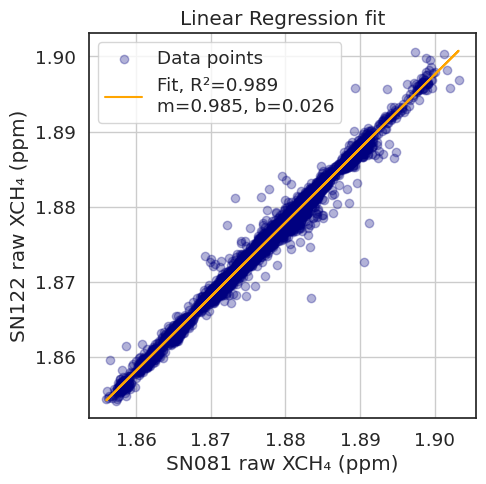

shape: (6_113, 1)
┌──────────┐
│ XCH4     │
│ ---      │
│ f64      │
╞══════════╡
│ 1.85584  │
│ 1.855929 │
│ 1.855259 │
│ 1.856382 │
│ 1.856057 │
│ …        │
│ 1.895496 │
│ 1.896323 │
│ 1.895545 │
│ 1.895397 │
│ 1.894659 │
└──────────┘


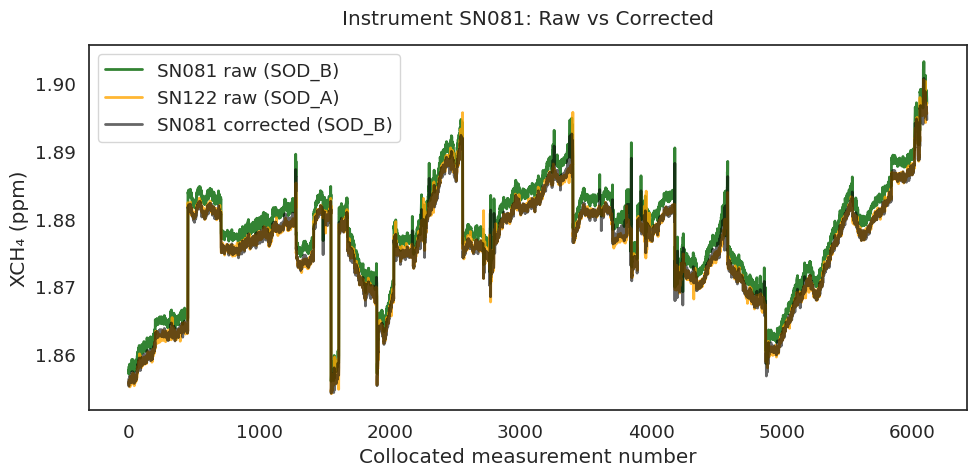

0.9849925127616551 0.026088498956902573


In [14]:
# calculate instrument bias correction XCH4
v = True
m_XCH4, b_XCH4, _ = create_bias_correction(
    locations_XCH4,
    XCH4.label,
    XCH4_PLOT_LABEL.label,
    v=v,
    show_plots=True
)
print(m_XCH4, b_XCH4)

Slope (m): 0.9950739405075896
Intercept (b): 2.1568030845182307
R² score: 0.9955608672124014


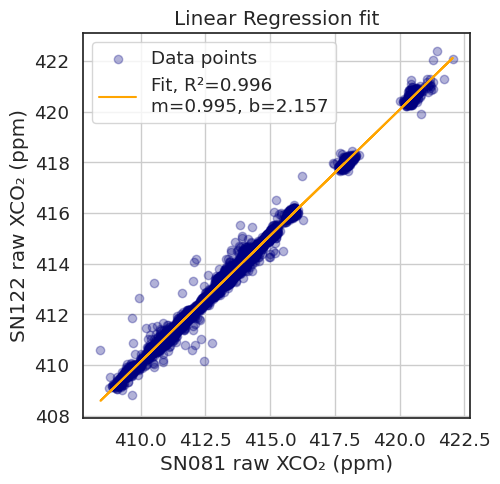

shape: (6_113, 1)
┌────────────┐
│ XCO2       │
│ ---        │
│ f64        │
╞════════════╡
│ 417.971336 │
│ 417.808144 │
│ 417.709631 │
│ 417.89372  │
│ 417.818094 │
│ …          │
│ 413.913424 │
│ 414.206971 │
│ 414.030843 │
│ 413.970144 │
│ 414.071641 │
└────────────┘


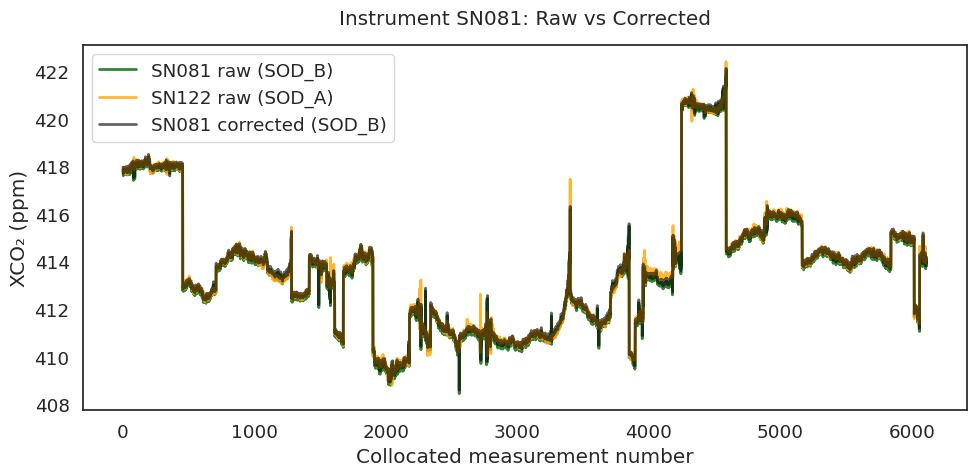

In [15]:
# calculate instrument bias correction XCO2
m_XCO2, b_XCO2, _ = create_bias_correction(
    locations_XCO2,
    XCO2.label,
    XCO2_PLOT_LABEL.label,
    v=v
)

Slope (m): 0.7698141836490249
Intercept (b): 0.018959676482800863
R² score: 0.6504564490901661


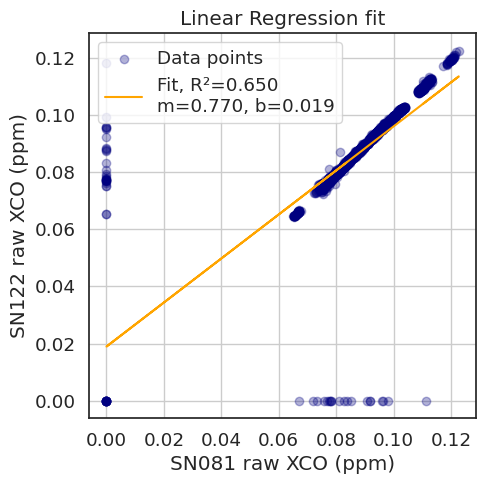

shape: (6_113, 1)
┌──────────┐
│ XCO      │
│ ---      │
│ f64      │
╞══════════╡
│ 0.083231 │
│ 0.083199 │
│ 0.083335 │
│ 0.083362 │
│ 0.083212 │
│ …        │
│ 0.103149 │
│ 0.10345  │
│ 0.103514 │
│ 0.103506 │
│ 0.10378  │
└──────────┘


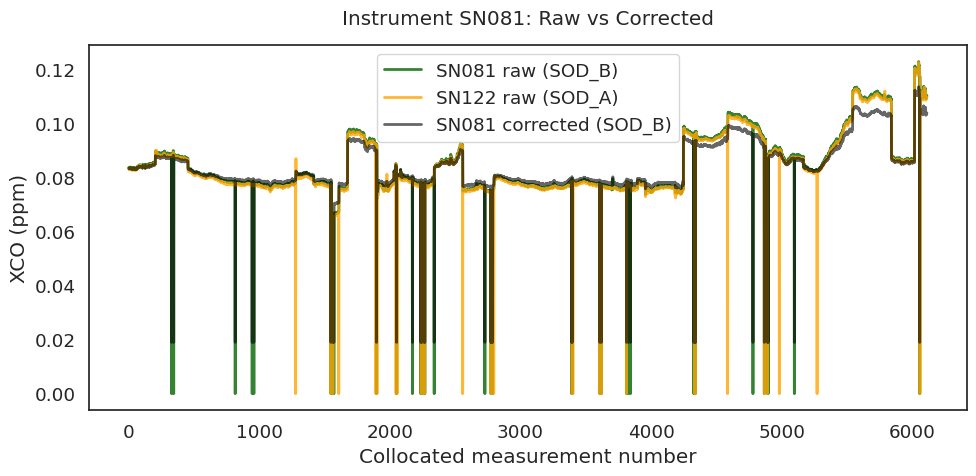

In [16]:
# calculate instrument bias correction XCO
m_XCO, b_XCO, _ = create_bias_correction(
    locations_XCO,
    XCO.label,
    XCO_PLOT_LABEL.label,
    v=v
)

Slope (m): 0.9579724605122529
Intercept (b): 0.04739725570971909
R² score: 0.7724885040029354


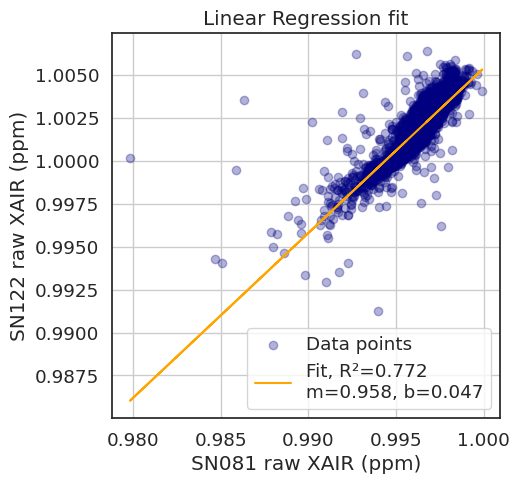

shape: (6_113, 1)
┌──────────┐
│ XAIR     │
│ ---      │
│ f64      │
╞══════════╡
│ 1.002225 │
│ 1.002488 │
│ 1.002712 │
│ 1.002172 │
│ 1.002275 │
│ …        │
│ 1.001149 │
│ 1.000526 │
│ 1.000812 │
│ 1.000989 │
│ 1.001149 │
└──────────┘


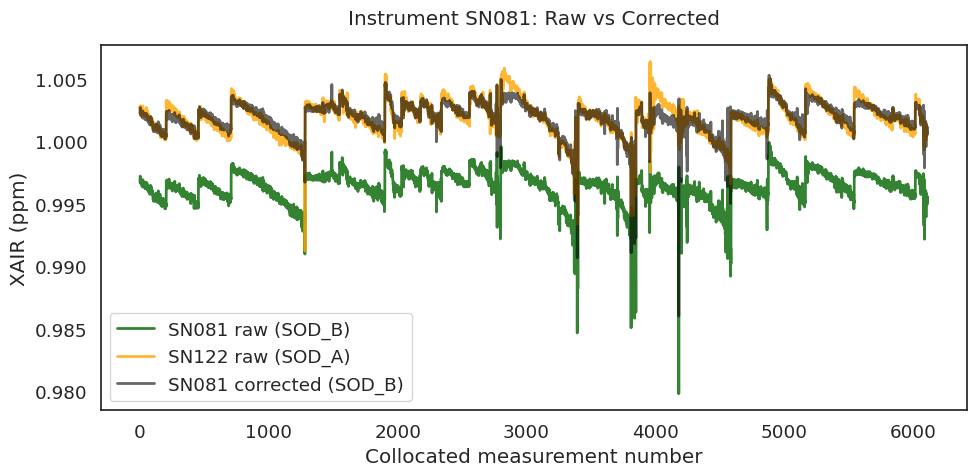

In [17]:
# calculate instrument bias correction XAIR
m_XAIR, b_XAIR, _ = create_bias_correction(
    locations_XAIR,
    XAIR.label,
    XAIR_PLOT_LABEL.label,
    v=v
)

In [18]:
# prepare corrected data for plotting XCH4
v = True
corr_raw_XCH4 = {
    INSTRUMENT_LOCATION_LABELS.SOD_A_122: locations_XCH4[INSTRUMENT_LOCATION_LABELS.SOD_A_122],
    INSTRUMENT_LOCATION_LABELS.SOD_B_081: apply_instrument_bias_correction(locations_XCH4[INSTRUMENT_LOCATION_LABELS.SOD_B_081], XCH4.label, m_XCH4, b_XCH4, v=v),
    INSTRUMENT_LOCATION_LABELS.SOD_A_081: apply_instrument_bias_correction(locations_XCH4[INSTRUMENT_LOCATION_LABELS.SOD_A_081], XCH4.label, m_XCH4, b_XCH4, v=v),
    INSTRUMENT_LOCATION_LABELS.HALSSIAAPA_A_122: locations_XCH4[INSTRUMENT_LOCATION_LABELS.HALSSIAAPA_A_122]
}
corr_daily_medians_XCH4 = {
    INSTRUMENT_LOCATION_LABELS.SOD_A_122: daily_medians_XCH4[INSTRUMENT_LOCATION_LABELS.SOD_A_122],
    INSTRUMENT_LOCATION_LABELS.SOD_B_081: apply_instrument_bias_correction(daily_medians_XCH4[INSTRUMENT_LOCATION_LABELS.SOD_B_081], XCH4.label, m_XCH4, b_XCH4, v=v),
    INSTRUMENT_LOCATION_LABELS.SOD_A_081: apply_instrument_bias_correction(daily_medians_XCH4[INSTRUMENT_LOCATION_LABELS.SOD_A_081], XCH4.label, m_XCH4, b_XCH4, v=v),
    INSTRUMENT_LOCATION_LABELS.HALSSIAAPA_A_122: daily_medians_XCH4[INSTRUMENT_LOCATION_LABELS.HALSSIAAPA_A_122]
}
corr_daily_means_XCH4 = {
    INSTRUMENT_LOCATION_LABELS.SOD_A_122: daily_means_XCH4[INSTRUMENT_LOCATION_LABELS.SOD_A_122],
    INSTRUMENT_LOCATION_LABELS.SOD_B_081: apply_instrument_bias_correction(daily_means_XCH4[INSTRUMENT_LOCATION_LABELS.SOD_B_081], XCH4.label, m_XCH4, b_XCH4, v=v),
    INSTRUMENT_LOCATION_LABELS.SOD_A_081: apply_instrument_bias_correction(daily_means_XCH4[INSTRUMENT_LOCATION_LABELS.SOD_A_081], XCH4.label, m_XCH4, b_XCH4, v=v),
    INSTRUMENT_LOCATION_LABELS.HALSSIAAPA_A_122: daily_means_XCH4[INSTRUMENT_LOCATION_LABELS.HALSSIAAPA_A_122]
}

shape: (6_113, 5)
┌──────────┬─────────────────────┬────────────┬───────────┬─────────────┐
│ XCH4     ┆ utc_minute          ┆ unix_epoch ┆ sensor_id ┆ location_id │
│ ---      ┆ ---                 ┆ ---        ┆ ---       ┆ ---         │
│ f64      ┆ datetime[ms]        ┆ f64        ┆ str       ┆ str         │
╞══════════╪═════════════════════╪════════════╪═══════════╪═════════════╡
│ 1.85584  ┆ 2022-05-24 08:48:00 ┆ 1.6534e9   ┆ SN081     ┆ SOD_B       │
│ 1.855929 ┆ 2022-05-24 08:49:00 ┆ 1.6534e9   ┆ SN081     ┆ SOD_B       │
│ 1.855259 ┆ 2022-05-24 08:50:00 ┆ 1.6534e9   ┆ SN081     ┆ SOD_B       │
│ 1.856382 ┆ 2022-05-24 08:51:00 ┆ 1.6534e9   ┆ SN081     ┆ SOD_B       │
│ 1.856057 ┆ 2022-05-24 08:53:00 ┆ 1.6534e9   ┆ SN081     ┆ SOD_B       │
│ …        ┆ …                   ┆ …          ┆ …         ┆ …           │
│ 1.895496 ┆ 2023-09-15 12:56:00 ┆ 1.6948e9   ┆ SN081     ┆ SOD_B       │
│ 1.896323 ┆ 2023-09-15 12:57:00 ┆ 1.6948e9   ┆ SN081     ┆ SOD_B       │
│ 1.895545 ┆ 2023-09

In [19]:
# prepare corrected data for plotting CO2
v = True
corr_raw_XCO2 = {
    INSTRUMENT_LOCATION_LABELS.SOD_A_122: locations_XCO2[INSTRUMENT_LOCATION_LABELS.SOD_A_122],
    INSTRUMENT_LOCATION_LABELS.SOD_B_081: apply_instrument_bias_correction(locations_XCO2[INSTRUMENT_LOCATION_LABELS.SOD_B_081], XCO2.label, m_XCO2, b_XCO2, v=v),
    INSTRUMENT_LOCATION_LABELS.SOD_A_081: apply_instrument_bias_correction(locations_XCO2[INSTRUMENT_LOCATION_LABELS.SOD_A_081], XCO2.label, m_XCO2, b_XCO2, v=v),
    INSTRUMENT_LOCATION_LABELS.HALSSIAAPA_A_122: locations_XCO2[INSTRUMENT_LOCATION_LABELS.HALSSIAAPA_A_122]
}
corr_daily_medians_XCO2 = {
    INSTRUMENT_LOCATION_LABELS.SOD_A_122: daily_medians_XCO2[INSTRUMENT_LOCATION_LABELS.SOD_A_122],
    INSTRUMENT_LOCATION_LABELS.SOD_B_081: apply_instrument_bias_correction(daily_medians_XCO2[INSTRUMENT_LOCATION_LABELS.SOD_B_081], XCO2.label, m_XCO2, b_XCO2, v=v),
    INSTRUMENT_LOCATION_LABELS.SOD_A_081: apply_instrument_bias_correction(daily_medians_XCO2[INSTRUMENT_LOCATION_LABELS.SOD_A_081], XCO2.label, m_XCO2, b_XCO2, v=v),
    INSTRUMENT_LOCATION_LABELS.HALSSIAAPA_A_122: daily_medians_XCO2[INSTRUMENT_LOCATION_LABELS.HALSSIAAPA_A_122]
}

shape: (6_113, 5)
┌────────────┬─────────────────────┬────────────┬───────────┬─────────────┐
│ XCO2       ┆ utc_minute          ┆ unix_epoch ┆ sensor_id ┆ location_id │
│ ---        ┆ ---                 ┆ ---        ┆ ---       ┆ ---         │
│ f64        ┆ datetime[ms]        ┆ f64        ┆ str       ┆ str         │
╞════════════╪═════════════════════╪════════════╪═══════════╪═════════════╡
│ 417.971336 ┆ 2022-05-24 08:48:00 ┆ 1.6534e9   ┆ SN081     ┆ SOD_B       │
│ 417.808144 ┆ 2022-05-24 08:49:00 ┆ 1.6534e9   ┆ SN081     ┆ SOD_B       │
│ 417.709631 ┆ 2022-05-24 08:50:00 ┆ 1.6534e9   ┆ SN081     ┆ SOD_B       │
│ 417.89372  ┆ 2022-05-24 08:51:00 ┆ 1.6534e9   ┆ SN081     ┆ SOD_B       │
│ 417.818094 ┆ 2022-05-24 08:53:00 ┆ 1.6534e9   ┆ SN081     ┆ SOD_B       │
│ …          ┆ …                   ┆ …          ┆ …         ┆ …           │
│ 413.913424 ┆ 2023-09-15 12:56:00 ┆ 1.6948e9   ┆ SN081     ┆ SOD_B       │
│ 414.206971 ┆ 2023-09-15 12:57:00 ┆ 1.6948e9   ┆ SN081     ┆ SOD_B   

In [20]:
# prepare corrected data for plotting CO2
v = True
corr_raw_XCO = {
    INSTRUMENT_LOCATION_LABELS.SOD_A_122: locations_XCO[INSTRUMENT_LOCATION_LABELS.SOD_A_122],
    INSTRUMENT_LOCATION_LABELS.SOD_B_081: apply_instrument_bias_correction(locations_XCO[INSTRUMENT_LOCATION_LABELS.SOD_B_081], XCO.label, m_XCO, b_XCO, v=v),
    INSTRUMENT_LOCATION_LABELS.SOD_A_081: apply_instrument_bias_correction(locations_XCO[INSTRUMENT_LOCATION_LABELS.SOD_A_081], XCO.label, m_XCO, b_XCO, v=v),
    INSTRUMENT_LOCATION_LABELS.HALSSIAAPA_A_122: locations_XCO[INSTRUMENT_LOCATION_LABELS.HALSSIAAPA_A_122]
}
corr_daily_medians_XCO = {
    INSTRUMENT_LOCATION_LABELS.SOD_A_122: daily_medians_XCO[INSTRUMENT_LOCATION_LABELS.SOD_A_122],
    INSTRUMENT_LOCATION_LABELS.SOD_B_081: apply_instrument_bias_correction(daily_medians_XCO[INSTRUMENT_LOCATION_LABELS.SOD_B_081], XCO.label, m_XCO, b_XCO, v=v),
    INSTRUMENT_LOCATION_LABELS.SOD_A_081: apply_instrument_bias_correction(daily_medians_XCO[INSTRUMENT_LOCATION_LABELS.SOD_A_081], XCO.label, m_XCO, b_XCO, v=v),
    INSTRUMENT_LOCATION_LABELS.HALSSIAAPA_A_122: daily_medians_XCO[INSTRUMENT_LOCATION_LABELS.HALSSIAAPA_A_122]
}

shape: (6_113, 5)
┌──────────┬─────────────────────┬────────────┬───────────┬─────────────┐
│ XCO      ┆ utc_minute          ┆ unix_epoch ┆ sensor_id ┆ location_id │
│ ---      ┆ ---                 ┆ ---        ┆ ---       ┆ ---         │
│ f64      ┆ datetime[ms]        ┆ f64        ┆ str       ┆ str         │
╞══════════╪═════════════════════╪════════════╪═══════════╪═════════════╡
│ 0.083231 ┆ 2022-05-24 08:48:00 ┆ 1.6534e9   ┆ SN081     ┆ SOD_B       │
│ 0.083199 ┆ 2022-05-24 08:49:00 ┆ 1.6534e9   ┆ SN081     ┆ SOD_B       │
│ 0.083335 ┆ 2022-05-24 08:50:00 ┆ 1.6534e9   ┆ SN081     ┆ SOD_B       │
│ 0.083362 ┆ 2022-05-24 08:51:00 ┆ 1.6534e9   ┆ SN081     ┆ SOD_B       │
│ 0.083212 ┆ 2022-05-24 08:53:00 ┆ 1.6534e9   ┆ SN081     ┆ SOD_B       │
│ …        ┆ …                   ┆ …          ┆ …         ┆ …           │
│ 0.103149 ┆ 2023-09-15 12:56:00 ┆ 1.6948e9   ┆ SN081     ┆ SOD_B       │
│ 0.10345  ┆ 2023-09-15 12:57:00 ┆ 1.6948e9   ┆ SN081     ┆ SOD_B       │
│ 0.103514 ┆ 2023-09

In [21]:
# prepare corrected data for plotting XAIR
v = True
corr_raw_XAIR = {
    INSTRUMENT_LOCATION_LABELS.SOD_A_122: locations_XAIR[INSTRUMENT_LOCATION_LABELS.SOD_A_122],
    INSTRUMENT_LOCATION_LABELS.SOD_B_081: apply_instrument_bias_correction(locations_XAIR[INSTRUMENT_LOCATION_LABELS.SOD_B_081], XAIR.label, m_XAIR, b_XAIR, v=v),
    INSTRUMENT_LOCATION_LABELS.SOD_A_081: apply_instrument_bias_correction(locations_XAIR[INSTRUMENT_LOCATION_LABELS.SOD_A_081], XAIR.label, m_XAIR, b_XAIR, v=v),
    INSTRUMENT_LOCATION_LABELS.HALSSIAAPA_A_122: locations_XAIR[INSTRUMENT_LOCATION_LABELS.HALSSIAAPA_A_122]
}
corr_daily_medians_XAIR = {
    INSTRUMENT_LOCATION_LABELS.SOD_A_122: daily_medians_XAIR[INSTRUMENT_LOCATION_LABELS.SOD_A_122],
    INSTRUMENT_LOCATION_LABELS.SOD_B_081: apply_instrument_bias_correction(daily_medians_XAIR[INSTRUMENT_LOCATION_LABELS.SOD_B_081], XAIR.label, m_XAIR, b_XAIR, v=v),
    INSTRUMENT_LOCATION_LABELS.SOD_A_081: apply_instrument_bias_correction(daily_medians_XAIR[INSTRUMENT_LOCATION_LABELS.SOD_A_081], XAIR.label, m_XAIR, b_XAIR, v=v),
    INSTRUMENT_LOCATION_LABELS.HALSSIAAPA_A_122: daily_medians_XAIR[INSTRUMENT_LOCATION_LABELS.HALSSIAAPA_A_122]
}

shape: (6_113, 5)
┌──────────┬─────────────────────┬────────────┬───────────┬─────────────┐
│ XAIR     ┆ utc_minute          ┆ unix_epoch ┆ sensor_id ┆ location_id │
│ ---      ┆ ---                 ┆ ---        ┆ ---       ┆ ---         │
│ f64      ┆ datetime[ms]        ┆ f64        ┆ str       ┆ str         │
╞══════════╪═════════════════════╪════════════╪═══════════╪═════════════╡
│ 1.002225 ┆ 2022-05-24 08:48:00 ┆ 1.6534e9   ┆ SN081     ┆ SOD_B       │
│ 1.002488 ┆ 2022-05-24 08:49:00 ┆ 1.6534e9   ┆ SN081     ┆ SOD_B       │
│ 1.002712 ┆ 2022-05-24 08:50:00 ┆ 1.6534e9   ┆ SN081     ┆ SOD_B       │
│ 1.002172 ┆ 2022-05-24 08:51:00 ┆ 1.6534e9   ┆ SN081     ┆ SOD_B       │
│ 1.002275 ┆ 2022-05-24 08:53:00 ┆ 1.6534e9   ┆ SN081     ┆ SOD_B       │
│ …        ┆ …                   ┆ …          ┆ …         ┆ …           │
│ 1.001149 ┆ 2023-09-15 12:56:00 ┆ 1.6948e9   ┆ SN081     ┆ SOD_B       │
│ 1.000526 ┆ 2023-09-15 12:57:00 ┆ 1.6948e9   ┆ SN081     ┆ SOD_B       │
│ 1.000812 ┆ 2023-09

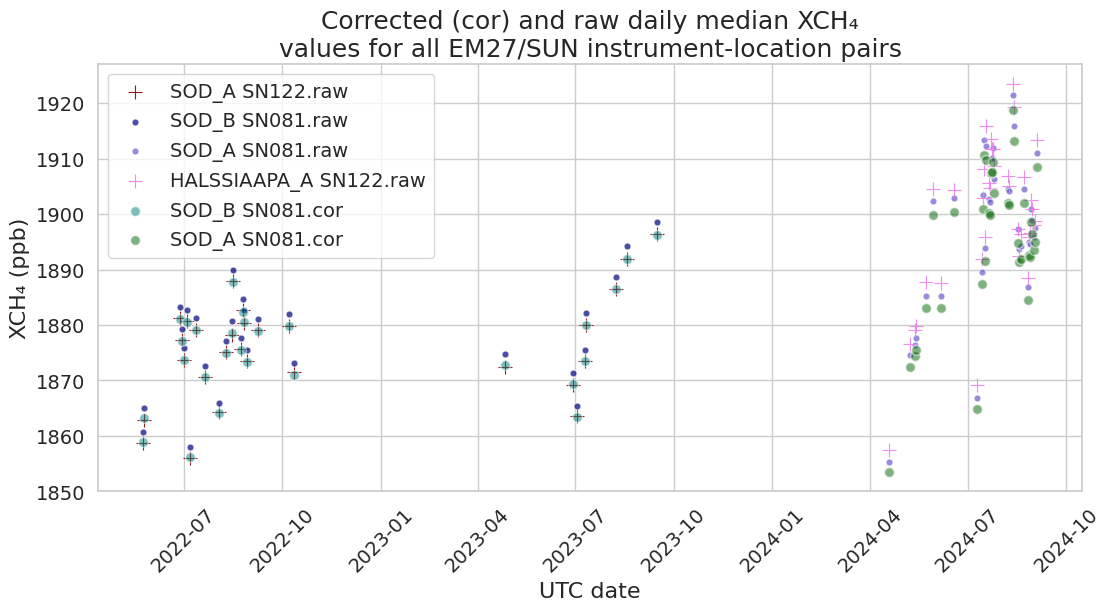

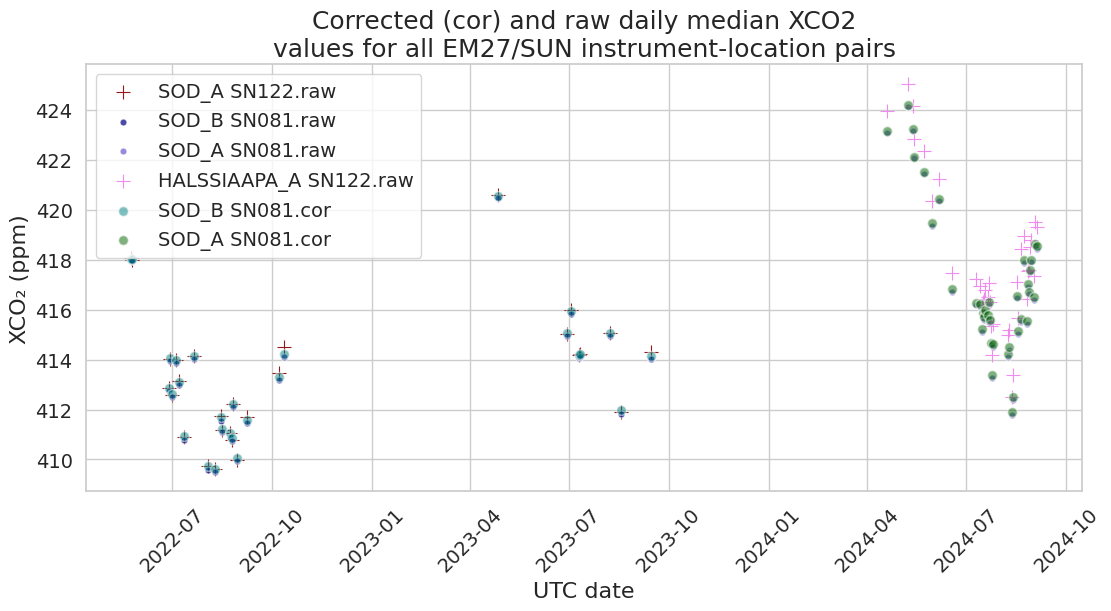

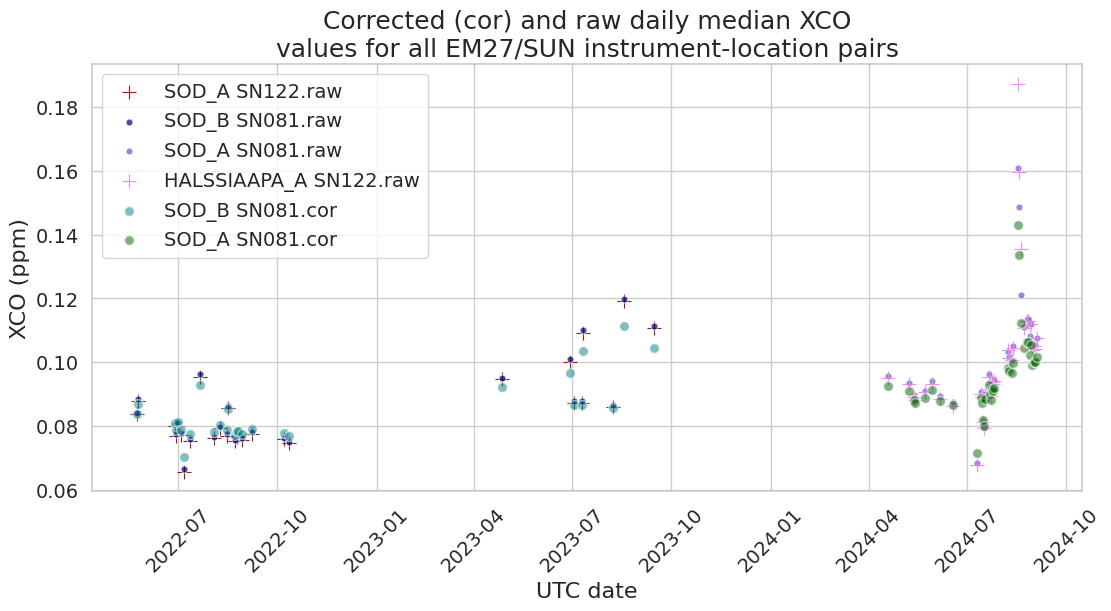

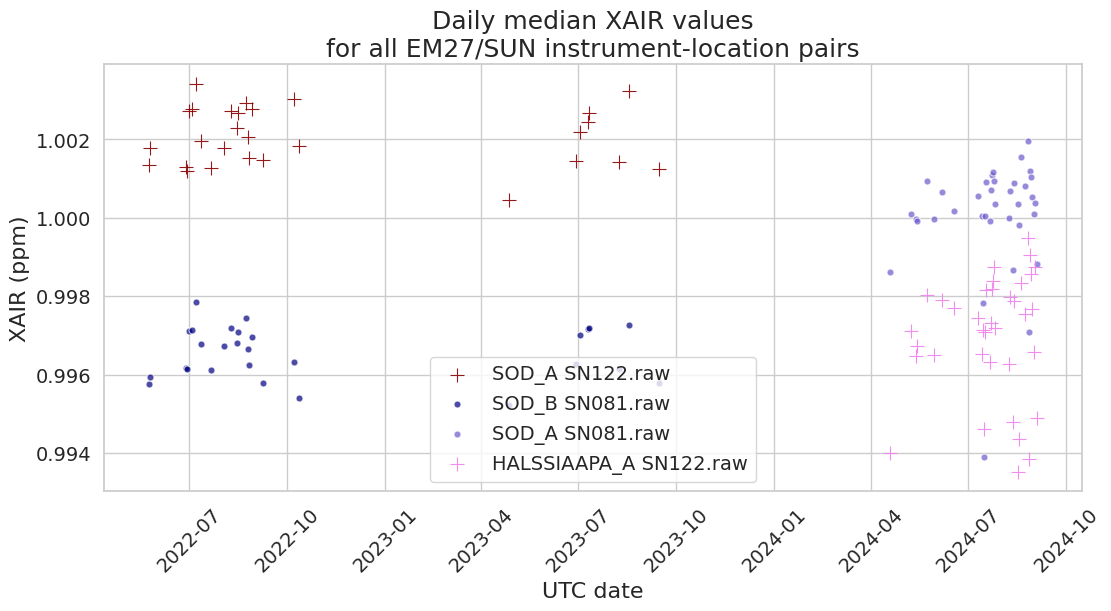

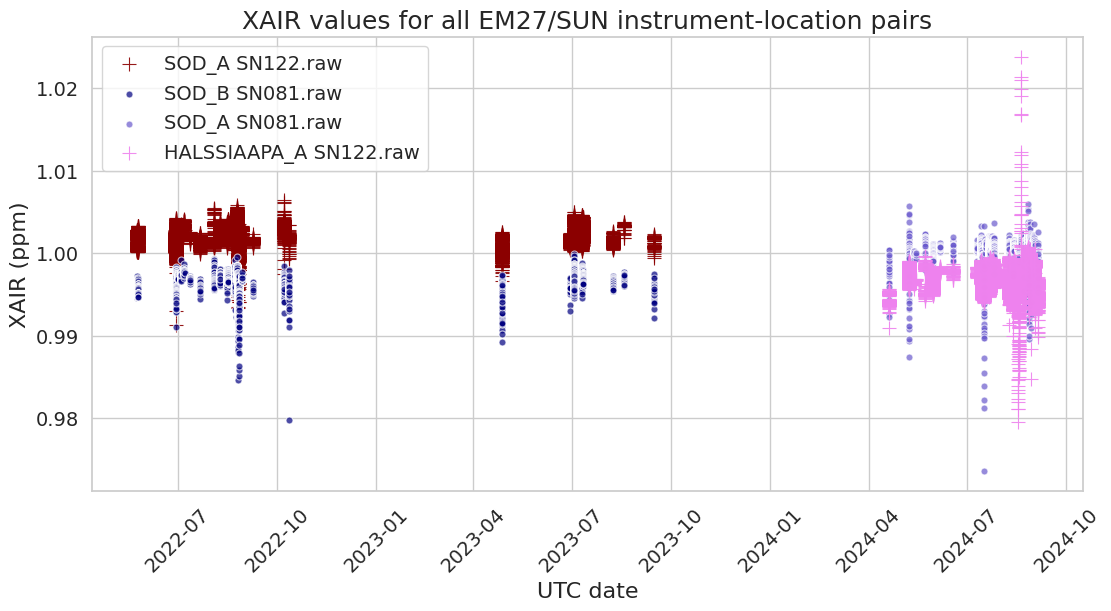

In [22]:
daily_medians_ppb_XCH4 = data_dict_ppm_to_ppb(daily_medians_XCH4)
corr_daily_medians_ppb_XCH4 = data_dict_ppm_to_ppb(corr_daily_medians_XCH4)

plt_raw_and_corrected_species(
    daily_medians_ppb_XCH4,
    x="day",
    y=f"{XCH4.label}.ppb",
    title="Corrected (cor) and raw daily median XCH₄\nvalues for all EM27/SUN instrument-location pairs",
    xlab="UTC date",
    ylab=XCH4_PPB_PLOT_LABEL.label,
    data_dict_corrected=corr_daily_medians_ppb_XCH4,
    # loc=(0.19,0.54)
    # fig_path = "fig/XCH¤_raw_corrected_medians_ppb.pdf"
)
plt_raw_and_corrected_species(
    daily_medians_XCO2,
    x="day",
    y=XCO2.label,
    title=f"Corrected (cor) and raw daily median {XCO2.label}\nvalues for all EM27/SUN instrument-location pairs",
    xlab="UTC date",
    ylab=XCO2_PLOT_LABEL.label,
    data_dict_corrected=corr_daily_medians_XCO2,
    # loc=(0.19,0.54)
    # fig_path = "fig/XCO2_raw_corrected_medians_ppm.pdf"
)
plt_raw_and_corrected_species(
    daily_medians_XCO,
    x="day",
    y=XCO.label,
    title=f"Corrected (cor) and raw daily median {XCO.label}\nvalues for all EM27/SUN instrument-location pairs",
    xlab="UTC date",
    ylab=XCO_PLOT_LABEL.label,
    data_dict_corrected=corr_daily_medians_XCO,
    # loc=(0.19,0.54)
    # fig_path = "fig/XCO_raw_corrected_medians_ppm.pdf"
)
plt_raw_and_corrected_species(
    daily_medians_XAIR,
    x="day",
    y=XAIR.label,
    title=f"Daily median {XAIR.label} values\nfor all EM27/SUN instrument-location pairs",
    xlab="UTC date",
    ylab=XAIR_PLOT_LABEL.label,
    # data_dict_corrected=corr_daily_medians_XCO,
    # loc=(0.19,0.54)
    # fig_path = "fig/XAIR_raw_corrected_medians_ppb.pdf"
)
plt_raw_and_corrected_species(
    locations_XAIR,
    x=UTC_MINUTE.label,
    y=XAIR.label,
    title=f"{XAIR.label} values for all EM27/SUN instrument-location pairs",
    xlab="UTC date",
    ylab=XAIR_PLOT_LABEL.label,
    # data_dict_corrected=corr_daily_medians_XCO,
    # loc=(0.19,0.54)
    # fig_path = "fig/xair_raw_all.pdf"
)

In [23]:
# Calculate residuals XCH4
v = True
corr_raw_XCH4_halssiaapa_residuals = calculate_halssiaapa_residuals(
    corr_raw_XCH4[INSTRUMENT_LOCATION_LABELS.HALSSIAAPA_A_122],
    corr_raw_XCH4[INSTRUMENT_LOCATION_LABELS.SOD_A_081],
    data_col_label=XCH4.label,
    time_col_label=UTC_MINUTE.label,
    res_col_label=XCH4_HALSSIAAPA_SOD_RES.label,
    v=v
)
corr_daily_medians_XCH4_halssiaapa_residuals = calculate_halssiaapa_residuals(
    corr_daily_medians_XCH4[INSTRUMENT_LOCATION_LABELS.HALSSIAAPA_A_122],
    corr_daily_medians_XCH4[INSTRUMENT_LOCATION_LABELS.SOD_A_081],
    data_col_label=XCH4.label,
    time_col_label="day",
    res_col_label=XCH4_HALSSIAAPA_SOD_RES.label,
    v=v
)


utc_minute,XCH4_HALSSIAAPA_A_122,XCH4_SOD_A_081,XCH4_HALSSIAAPA_SOD_RES
datetime[ms],f64,f64,f64
2024-04-19 12:46:00,1.85154,1.848088,0.003452
2024-04-19 12:47:00,1.85111,1.847399,0.003711
2024-04-19 12:48:00,1.85168,1.846906,0.004774
2024-04-19 12:49:00,1.85175,1.847212,0.004538
2024-04-19 12:50:00,1.85194,1.847271,0.004669
…,…,…,…
2024-09-04 15:36:00,1.90664,1.904164,0.002476
2024-09-04 15:37:00,1.90775,1.904134,0.003616
2024-09-04 15:38:00,1.90676,1.905366,0.001394


day,XCH4_HALSSIAAPA_A_122,XCH4_SOD_A_081,XCH4_HALSSIAAPA_SOD_RES
datetime[ms],f64,f64,f64
2024-04-19 00:00:00,1.857455,1.853481,0.003974
2024-05-08 00:00:00,1.87665,1.872452,0.004198
2024-05-13 00:00:00,1.879135,1.874397,0.004738
2024-05-14 00:00:00,1.87973,1.875491,0.004239
2024-05-23 00:00:00,1.8877,1.883065,0.004635
…,…,…,…
2024-08-29 00:00:00,1.902465,1.898544,0.003921
2024-08-30 00:00:00,1.900975,1.896451,0.004524
2024-09-01 00:00:00,1.89806,1.893427,0.004633


In [24]:
# Calculate residuals XCO2
v = True
corr_raw_XCO2_halssiaapa_residuals = calculate_halssiaapa_residuals(
    corr_raw_XCO2[INSTRUMENT_LOCATION_LABELS.HALSSIAAPA_A_122],
    corr_raw_XCO2[INSTRUMENT_LOCATION_LABELS.SOD_A_081],
    data_col_label=XCO2.label,
    time_col_label=UTC_MINUTE.label,
    res_col_label=XCO2_HALSSIAAPA_SOD_RES.label,
    v=v
)
corr_daily_medians_XCO2_halssiaapa_residuals = calculate_halssiaapa_residuals(
    corr_daily_medians_XCO2[INSTRUMENT_LOCATION_LABELS.HALSSIAAPA_A_122],
    corr_daily_medians_XCO2[INSTRUMENT_LOCATION_LABELS.SOD_A_081],
    data_col_label=XCO2.label,
    time_col_label="day",
    res_col_label=XCO2_HALSSIAAPA_SOD_RES.label,
    v=v
)

utc_minute,XCO2_HALSSIAAPA_A_122,XCO2_SOD_A_081,XCO2_HALSSIAAPA_SOD_RES
datetime[ms],f64,f64,f64
2024-04-19 12:46:00,424.149,423.376577,0.772423
2024-04-19 12:47:00,424.121,423.293986,0.827014
2024-04-19 12:48:00,424.103,423.290006,0.812994
2024-04-19 12:49:00,424.139,423.294981,0.844019
2024-04-19 12:50:00,424.215,423.194479,1.020521
…,…,…,…
2024-09-04 15:36:00,419.691,419.210203,0.480797
2024-09-04 15:37:00,419.861,419.104725,0.756275
2024-09-04 15:38:00,419.833,419.328617,0.504383


day,XCO2_HALSSIAAPA_A_122,XCO2_SOD_A_081,XCO2_HALSSIAAPA_SOD_RES
datetime[ms],f64,f64,f64
2024-04-19 00:00:00,423.9635,423.150198,0.813302
2024-05-08 00:00:00,425.0415,424.201494,0.840006
2024-05-13 00:00:00,424.161,423.223834,0.937166
2024-05-14 00:00:00,422.85,422.130745,0.719255
2024-05-23 00:00:00,422.371,421.519769,0.851231
…,…,…,…
2024-08-29 00:00:00,418.524,417.59669,0.92731
2024-08-30 00:00:00,418.776,417.995218,0.780782
2024-09-01 00:00:00,417.358,416.488676,0.869324


In [25]:
# Calculate residuals XCO
corr_raw_XCO_halssiaapa_residuals = calculate_halssiaapa_residuals(
    locations_XCO[INSTRUMENT_LOCATION_LABELS.HALSSIAAPA_A_122], # Do not use corrected version because correction doesn't improve bias
    locations_XCO[INSTRUMENT_LOCATION_LABELS.SOD_A_081],
    data_col_label=XCO.label,
    time_col_label=UTC_MINUTE.label,
    res_col_label=XCO_HALSSIAAPA_SOD_RES.label,
    v=v
)
corr_daily_medians_XCO_halssiaapa_residuals = calculate_halssiaapa_residuals(
    daily_medians_XCO[INSTRUMENT_LOCATION_LABELS.HALSSIAAPA_A_122],
    daily_medians_XCO[INSTRUMENT_LOCATION_LABELS.SOD_A_081],
    data_col_label=XCO.label,
    time_col_label="day",
    res_col_label=XCO_HALSSIAAPA_SOD_RES.label,
    v=v
)


utc_minute,XCO_HALSSIAAPA_A_122,XCO_SOD_A_081,XCO_HALSSIAAPA_SOD_RES
datetime[ms],f64,f64,f64
2024-04-19 12:46:00,0.0905233,0.0907214,-0.000198
2024-04-19 12:47:00,0.0905314,0.0905242,0.000007
2024-04-19 12:48:00,0.0904794,0.090961,-0.000482
2024-04-19 12:49:00,0.0904987,0.0913795,-0.000881
2024-04-19 12:50:00,0.0906526,0.0914539,-0.000801
…,…,…,…
2024-09-04 15:36:00,0.107554,0.107608,-0.000054
2024-09-04 15:37:00,0.107761,0.108087,-0.000326
2024-09-04 15:38:00,0.10815,0.10837,-0.00022


day,XCO_HALSSIAAPA_A_122,XCO_SOD_A_081,XCO_HALSSIAAPA_SOD_RES
datetime[ms],f64,f64,f64
2024-04-19 00:00:00,0.0951401,0.095615,-0.000475
2024-05-08 00:00:00,0.093279,0.0935532,-0.000274
2024-05-13 00:00:00,0.089091,0.0896943,-0.000603
2024-05-14 00:00:00,0.0881332,0.0886217,-0.000489
2024-05-23 00:00:00,0.0906317,0.0908441,-0.000212
…,…,…,…
2024-08-29 00:00:00,0.1118805,0.112091,-0.000211
2024-08-30 00:00:00,0.103886,0.104257,-0.000371
2024-09-01 00:00:00,0.105205,0.105444,-0.000239


In [26]:
# Calculate residuals XAIR
v = True
corr_raw_XAIR_halssiaapa_residuals = calculate_halssiaapa_residuals(
    corr_raw_XAIR[INSTRUMENT_LOCATION_LABELS.HALSSIAAPA_A_122],
    corr_raw_XAIR[INSTRUMENT_LOCATION_LABELS.SOD_A_081],
    data_col_label=XAIR.label,
    time_col_label=UTC_MINUTE.label,
    res_col_label=XAIR_HALSSIAAPA_SOD_RES.label,
    v=v
)
corr_daily_medians_XAIR_halssiaapa_residuals = calculate_halssiaapa_residuals(
    corr_daily_medians_XAIR[INSTRUMENT_LOCATION_LABELS.HALSSIAAPA_A_122],
    corr_daily_medians_XAIR[INSTRUMENT_LOCATION_LABELS.SOD_A_081],
    data_col_label=XAIR.label,
    time_col_label="day",
    res_col_label=XAIR_HALSSIAAPA_SOD_RES.label,
    v=v
)

utc_minute,XAIR_HALSSIAAPA_A_122,XAIR_SOD_A_081,XAIR_HALSSIAAPA_SOD_RES
datetime[ms],f64,f64,f64
2024-04-19 12:46:00,0.99544,1.004526,-0.009086
2024-04-19 12:47:00,0.995672,1.004896,-0.009224
2024-04-19 12:48:00,0.99553,1.005238,-0.009708
2024-04-19 12:49:00,0.995691,1.005039,-0.009348
2024-04-19 12:50:00,0.995321,1.004943,-0.009622
…,…,…,…
2024-09-04 15:36:00,0.993012,1.002453,-0.009441
2024-09-04 15:37:00,0.991946,1.001413,-0.009467
2024-09-04 15:38:00,0.990412,1.000831,-0.010419


day,XAIR_HALSSIAAPA_A_122,XAIR_SOD_A_081,XAIR_HALSSIAAPA_SOD_RES
datetime[ms],f64,f64,f64
2024-04-19 00:00:00,0.994008,1.004048,-0.01004
2024-05-08 00:00:00,0.997119,1.005456,-0.008337
2024-05-13 00:00:00,0.996485,1.005331,-0.008846
2024-05-14 00:00:00,0.99672,1.005291,-0.008571
2024-05-23 00:00:00,0.998027,1.00628,-0.008253
…,…,…,…
2024-08-29 00:00:00,0.9985675,1.006356,-0.007789
2024-08-30 00:00:00,0.997674,1.005887,-0.008213
2024-09-01 00:00:00,0.996582,1.005466,-0.008884


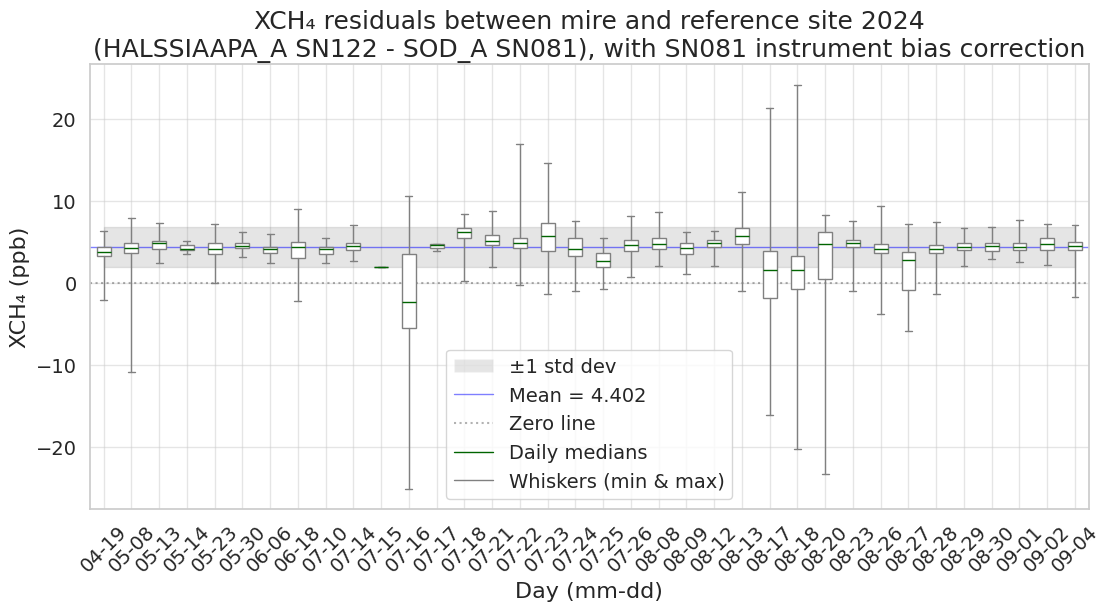

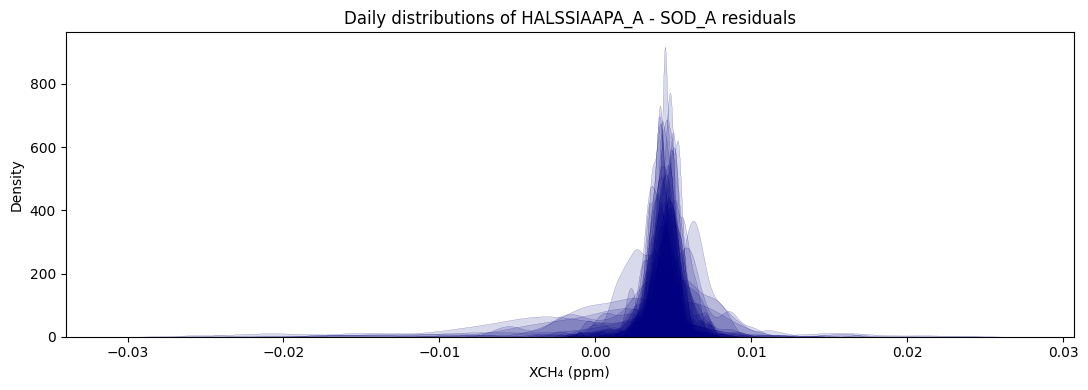

In [ ]:

corr_raw_ppb_XCH4 = data_dict_ppm_to_ppb(corr_raw_XCH4)

corr_raw_ppb_XCH4_halssiaapa_residuals = calculate_halssiaapa_residuals(
    corr_raw_ppb_XCH4[INSTRUMENT_LOCATION_LABELS.HALSSIAAPA_A_122],
    corr_raw_ppb_XCH4[INSTRUMENT_LOCATION_LABELS.SOD_A_081],
    data_col_label=f"{XCH4.label}.ppb",
    time_col_label=UTC_MINUTE.label,
    res_col_label=f"{XCH4_HALSSIAAPA_SOD_RES.label}.ppb",
    v=False
)

plt_box_residuals(
    corr_raw_ppb_XCH4_halssiaapa_residuals,
    res_column_label=f"{XCH4_HALSSIAAPA_SOD_RES.label}.ppb",
    title="XCH₄ residuals between mire and reference site 2024\n(HALSSIAAPA_A SN122 - SOD_A SN081), with SN081 instrument bias correction",
    y_lab=XCH4_PPB_PLOT_LABEL.label,
    # fig_path = "fig/box_ch4_ppb.pdf"
)

plt_res_distro(
    corr_raw_XCH4_halssiaapa_residuals,
    res_col_label='XCH4_HALSSIAAPA_SOD_RES',
    y_label=XCH4_PLOT_LABEL.label
)

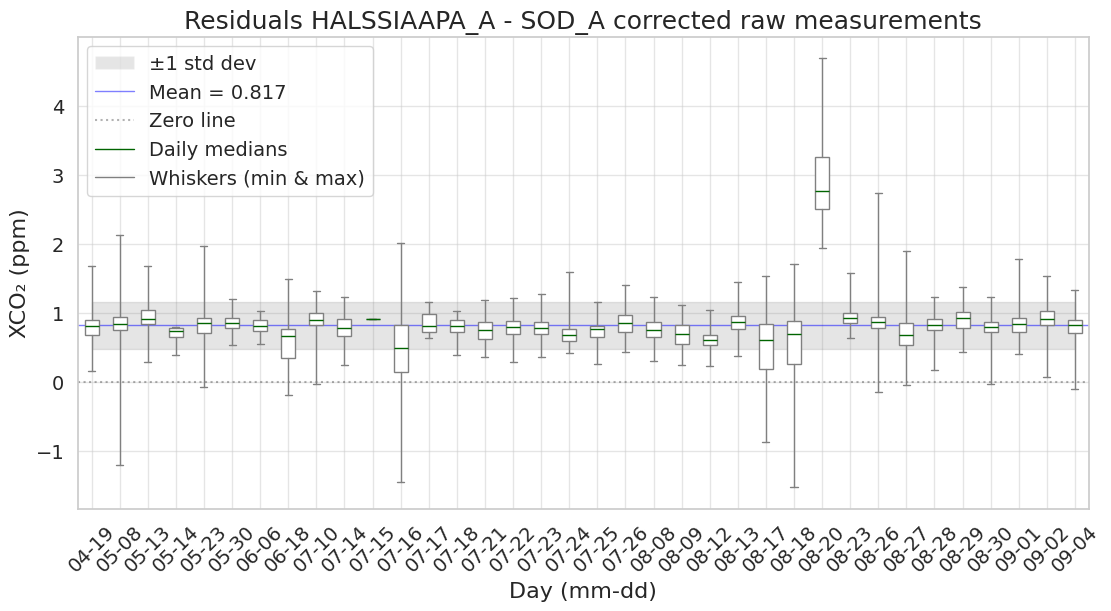

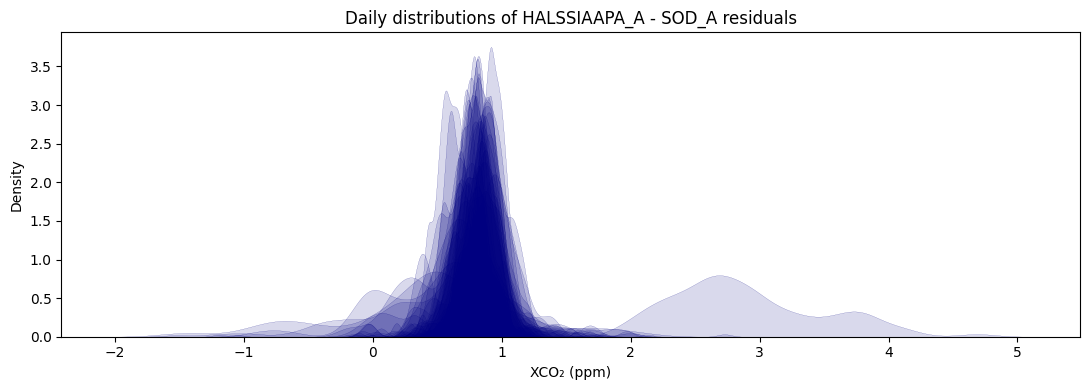

In [ ]:
# Plot residuals XCO2
plt_box_residuals(
    corr_raw_XCO2_halssiaapa_residuals,
    res_column_label=XCO2_HALSSIAAPA_SOD_RES.label,
    title="Residuals HALSSIAAPA_A - SOD_A corrected raw measurements",
    y_lab=XCO2_PLOT_LABEL.label,
)
plt_res_distro(
    corr_raw_XCO2_halssiaapa_residuals,
    res_col_label='XCO2_HALSSIAAPA_SOD_RES',
    y_label=XCO2_PLOT_LABEL.label
)

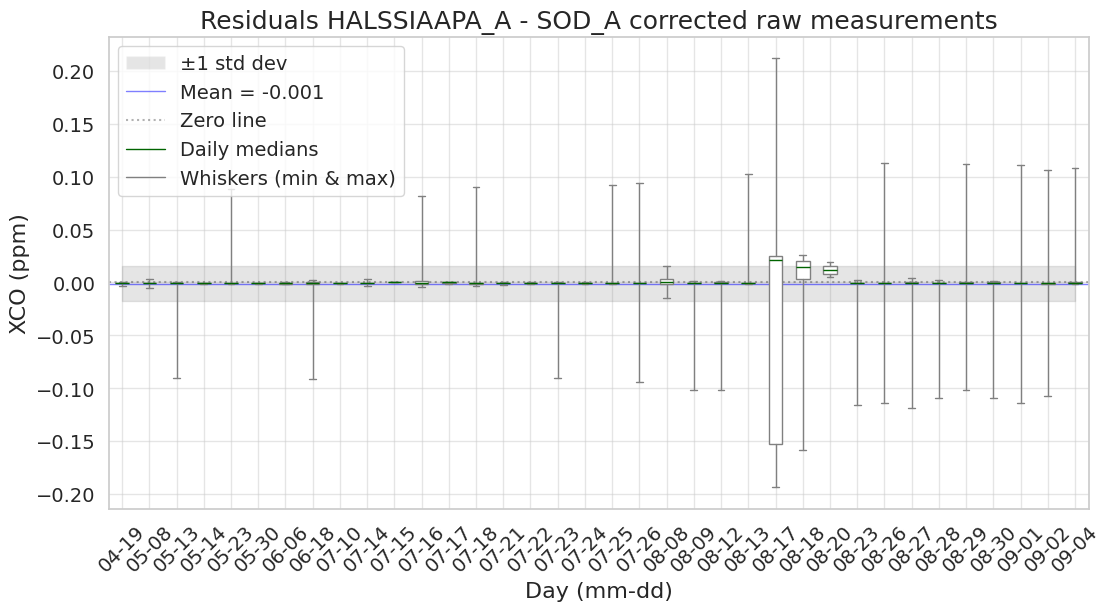

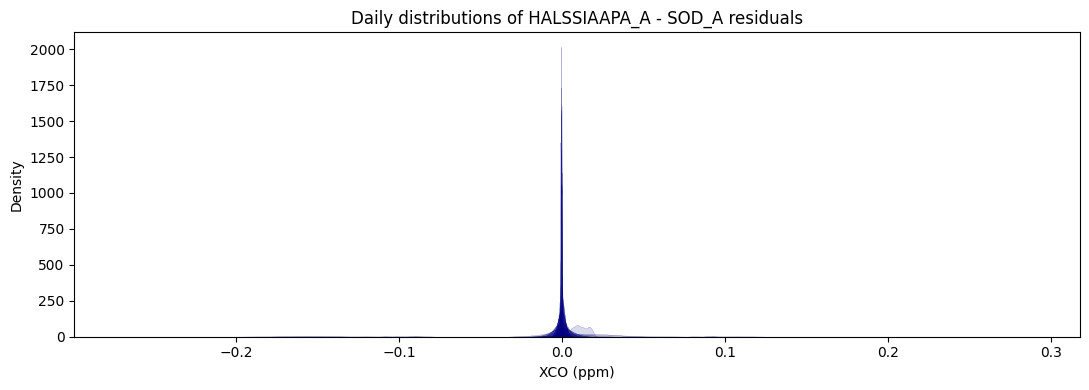

In [29]:
# Plot residuals XCO
plt_box_residuals(
    corr_raw_XCO_halssiaapa_residuals,
    res_column_label=XCO_HALSSIAAPA_SOD_RES.label,
    title="Residuals HALSSIAAPA_A - SOD_A corrected raw measurements",
    y_lab=XCO_PLOT_LABEL.label,
)
plt_res_distro(
    corr_raw_XCO_halssiaapa_residuals,
    res_col_label='XCO_HALSSIAAPA_SOD_RES',
    y_label=XCO_PLOT_LABEL.label
)

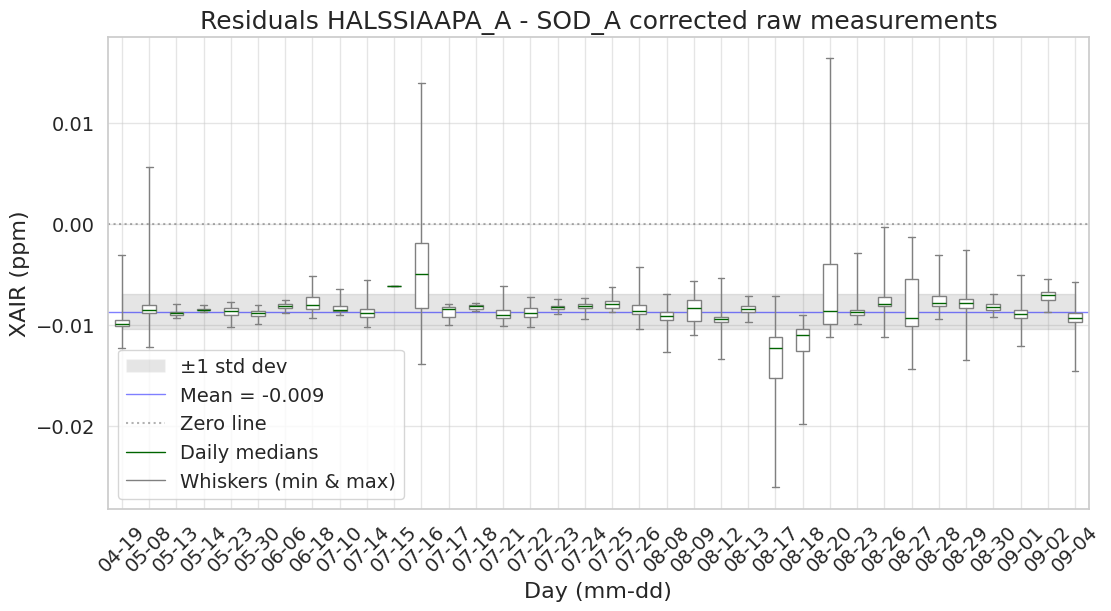

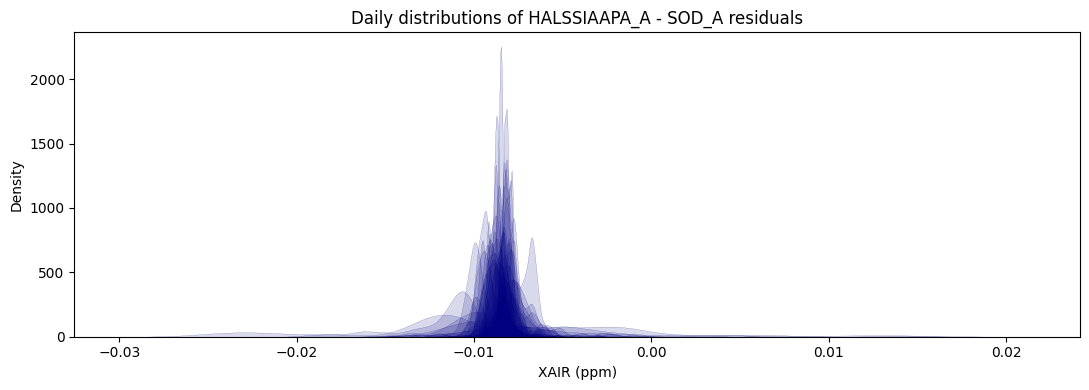

In [30]:
# Plot residuals XAIR
plt_box_residuals(
    corr_raw_XAIR_halssiaapa_residuals,
    res_column_label=XAIR_HALSSIAAPA_SOD_RES.label,
    title="Residuals HALSSIAAPA_A - SOD_A corrected raw measurements",
    y_lab=XAIR_PLOT_LABEL.label,
)
plt_res_distro(
    corr_raw_XAIR_halssiaapa_residuals,
    res_col_label='XAIR_HALSSIAAPA_SOD_RES',
    y_label=XAIR_PLOT_LABEL.label
)